# INX Future Inc. Employee Performance Evaluation

## Project Summary

his project is used to analyze employee performance data from INX Future Inc. Here we  uncover the most important drivers of performance which will be used to support data-driven HR decisions. We began by analyzing the dataset and moved on with **feature engineering**, were meaningful variables such as Promotion Wait Time were created. We then moved to **exploratory data analysis (EDA)** to understand feature distributions, class imbalance, and department-level performances.

We then trained and evaluated **supervised machine learning models**, such as Multinomial Logistic Regression (with L2 regularization), Random Forest, and XGBoost to predict employee performance ratings as given (2 = Good, 3 = Excellent, 4 = Outstanding). All the models were evaluated using **precision, Recall, F1-scores, confusion matrices**, and **ROC-AUC** to account for class imbalance.

The  XGBoost model was the winning model and achieved **94% overall accuracy** and **90% F1-score for top performers**, which demonstrates its strong predictive power. No feature selection was performed because we didn't want to lose any signal, but we then used **feature importance**  to identify the most impactful drivers after modeling.

Key preprocessing and engineering steps included:  
- **Data cleaning**: We handled missing values that came after feature engineering, and standardized categorical labels.  
- **Feature engineering**: We created new features from existing ones and grouped small categories.
- **exploratory data analysis (EDA)**: Here we performed Univariate and Bivariate analysis.We uncovered insights and also plotted a correlation heatmap.
- **Categorical encoding**: We used target encoding for high-cardinality features, one-hot encoding for low-cardinality variables, and binary mapping for yes/no fields and finally, label encoding for the target variable.  
- **Scaling**: This was applied to numeric features for Logistic Regression. Our tree-based models used the raw values.  
- **Stratified train-test split** was used to preserve class distributions and ensure fair evaluation.

This Analysis revealed that performance is primarily driven by **Work Environment Satisfaction, Time Since Last Promotion, and Recent Salary Hike**, not demographics like gender or commute distance. The model can help identify high-performing profiles, though some care is needed to avoid using the post-hire features in pre-hire decisions.

---


## 1. **Importing the Required Libraries**

In [1]:
# include the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, 
                             classification_report, roc_auc_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# The output should show all columns and prevent line wrapping
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Remove gridlines
sns.set_style("white") 

print('The Libraries have been successfully imported')

The Libraries have been successfully imported


## 2. **Loading the Dataset**

In [2]:
# The dataset is in excel format, so we use read_excel

df_orig = pd.read_excel("INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls")

print('The dataset has been successfully loaded')


The dataset has been successfully loaded


## **3. Dataset Overview**

In [3]:
# let's check the first 5 rows

df_orig.head()

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,4,55,3,2,4,1,No,12,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,4,42,3,2,1,2,No,12,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,4,48,2,3,1,5,Yes,21,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,2,73,2,5,4,3,No,15,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,1,84,3,2,1,8,No,14,4,10,1,3,2,2,2,2,No,3


### **i. Check the information of each column**

In [4]:
# let's check the information of our dataset

print(df_orig.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   EmpNumber                     1200 non-null   object
 1   Age                           1200 non-null   int64 
 2   Gender                        1200 non-null   object
 3   EducationBackground           1200 non-null   object
 4   MaritalStatus                 1200 non-null   object
 5   EmpDepartment                 1200 non-null   object
 6   EmpJobRole                    1200 non-null   object
 7   BusinessTravelFrequency       1200 non-null   object
 8   DistanceFromHome              1200 non-null   int64 
 9   EmpEducationLevel             1200 non-null   int64 
 10  EmpEnvironmentSatisfaction    1200 non-null   int64 
 11  EmpHourlyRate                 1200 non-null   int64 
 12  EmpJobInvolvement             1200 non-null   int64 
 13  EmpJobLevel       

**COMMENT**
- At first glance, i notice the `EmpNumber` column which is the ID for each employee and it has no predictive value. We won't need in our analysis so we will drop it later on. 

- Our target variable is **PerformanceRating**

- The dataset contains 19 numerical columns and 9 categorical columns and 1200 rows. We will need to encode these categorical variables for modelling purposes.

But before making any changes let's discover some more about the dataset

### **ii. Check the shape of the dataset and unique values in each column**

In [5]:
# let's check the shape of our dataframe
print(f'We have {df_orig.shape[1]} columns and {df_orig.shape[0]} rows\n')

# Then analyze the number of unique values per column
print("Here are the number of unique values per column:\n")
for col in df_orig.columns:
    print(f'{col}:{df_orig[col].nunique()}')

We have 28 columns and 1200 rows

Here are the number of unique values per column:

EmpNumber:1200
Age:43
Gender:2
EducationBackground:6
MaritalStatus:3
EmpDepartment:6
EmpJobRole:19
BusinessTravelFrequency:3
DistanceFromHome:29
EmpEducationLevel:5
EmpEnvironmentSatisfaction:4
EmpHourlyRate:71
EmpJobInvolvement:4
EmpJobLevel:5
EmpJobSatisfaction:4
NumCompaniesWorked:10
OverTime:2
EmpLastSalaryHikePercent:15
EmpRelationshipSatisfaction:4
TotalWorkExperienceInYears:40
TrainingTimesLastYear:7
EmpWorkLifeBalance:4
ExperienceYearsAtThisCompany:37
ExperienceYearsInCurrentRole:19
YearsSinceLastPromotion:16
YearsWithCurrManager:18
Attrition:2
PerformanceRating:3


### iii. The values in our target variable

In [6]:
df_orig.value_counts('PerformanceRating')

PerformanceRating
3    874
2    194
4    132
Name: count, dtype: int64

**COMMENT**

We have imbalanced classes, so we'll ensure stratification during modelling.

### **iv. Check for missing values and duplicates**

In [7]:
# let'scheck for missing values
df_orig.isnull().sum()

EmpNumber                       0
Age                             0
Gender                          0
EducationBackground             0
MaritalStatus                   0
EmpDepartment                   0
EmpJobRole                      0
BusinessTravelFrequency         0
DistanceFromHome                0
EmpEducationLevel               0
EmpEnvironmentSatisfaction      0
EmpHourlyRate                   0
EmpJobInvolvement               0
EmpJobLevel                     0
EmpJobSatisfaction              0
NumCompaniesWorked              0
OverTime                        0
EmpLastSalaryHikePercent        0
EmpRelationshipSatisfaction     0
TotalWorkExperienceInYears      0
TrainingTimesLastYear           0
EmpWorkLifeBalance              0
ExperienceYearsAtThisCompany    0
ExperienceYearsInCurrentRole    0
YearsSinceLastPromotion         0
YearsWithCurrManager            0
Attrition                       0
PerformanceRating               0
dtype: int64

In [8]:
# let's find if we have duplicates

df_orig.duplicated().sum()

np.int64(0)

**COMMENT**

Great News !! We have no missing values or duplicates in our dataset. We can go ahead and check the summary statistics of our data.


### **v. The summary statistics of the numerical columns**

In [9]:
df_orig.describe()

,Age,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating
count,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,36.918333,9.165833,2.89250,2.715833,65.981667,2.731667,2.067500,2.732500,2.665000,15.222500,2.725000,11.330000,2.785833,2.744167,7.077500,4.291667,2.194167,4.105000,2.948333
std,9.087289,8.176636,1.04412,1.090599,20.211302,0.707164,1.107836,1.100888,2.469384,3.625918,1.075642,7.797228,1.263446,0.699374,6.236899,3.613744,3.221560,3.541576,0.518866
min,18.000000,1.000000,1.00000,1.000000,30.000000,1.000000,1.000000,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,30.000000,2.000000,2.00000,2.000000,48.000000,2.000000,1.000000,2.000000,1.000000,12.000000,2.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,3.000000
50%,36.000000,7.000000,3.00000,3.000000,66.000000,3.000000,2.000000,3.000000,2.000000,14.000000,3.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,3.000000
75%,43.000000,14.000000,4.00000,4.000000,83.000000,3.000000,3.000000,4.000000,4.000000,18.000000,4.000000,15.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000,3.000000
max,60.000000,29.000000,5.00000,4.000000,100.000000,4.000000,5.000000,4.000000,9.000000,25.000000,4.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,4.000000


**COMMENT**

I notice some numeric features have very different ranges, for example, `EmpHourlyRate` with a  65.98  mean  and EmpJobLevel with a 2.07 mean. To make sure none of them dominates the Multinomial Logistic Regression model, we will scale these numeric columns. Apart from that nothing looks out of order apart from a few outliers.

### **vi. Make a copy of the original DataFrame and drop Column**

In [10]:
# Let's drop the Employee number column as it is not useful for our analysis
# Any changes will be made to a copy of the original dataframe keeping it intact

df = df_orig.copy()

df = df.drop(['EmpNumber'], axis = 1)

print('column successfully dropped')

column successfully dropped


---
## **4. Feature Engineering**
We combined some features to create ratios that give us a better view of their relation to perfomance score and also to give the model stronger signals to work with.

1. **CompanyExperienceShare** - Simply put it is how much of their total career was spent at this company
2. **RoleStabilityScore** - This helps us understand how long an employee has been in their current role compared to their total time at the company.
3. **CommuteCategory** - Instead of using raw distance numbers, we grouped them into Near/Moderate/Far to make it easier to see whether commute stress could be affecting performance.
4. **PromotionWaitTime** - This converts years since last promotion into Recent/Moderate/Long to reflect how the time gap since an employee got a promotion
Now let's get into it!

### **i. Create features**

In [11]:
# Company Experience Share column

df['CompanyExperienceShare'] = df['ExperienceYearsAtThisCompany'] / df['TotalWorkExperienceInYears']

# Roles Stability Score column

df['RoleStabilityScore'] = df['ExperienceYearsInCurrentRole'] / df['ExperienceYearsAtThisCompany']

# Commute category column (0–5 km --> Near, 5–15 km --> Moderate, 15–30 km --> Far)

df['CommuteCategory'] = pd.cut(df['DistanceFromHome'], bins = [0,5,15,30], 
                               labels=['Near', 'Moderate', 'Far'])

# Promotion Wait Time column (-1 to 1 --> Recent, 1 to 4 --> "Moderate", 4 to 16 --> "Long")

df['PromotionWaitTime'] = pd.cut(df['YearsSinceLastPromotion'], bins= [-1, 1, 4, 16],
                                 labels = ['Recent', 'Moderate', 'Long'])

print('The Features have been successfully created\n')
print(df.head(2))


The Features have been successfully created

   Age Gender EducationBackground MaritalStatus EmpDepartment       EmpJobRole BusinessTravelFrequency  DistanceFromHome  EmpEducationLevel  EmpEnvironmentSatisfaction  EmpHourlyRate  EmpJobInvolvement  EmpJobLevel  EmpJobSatisfaction  NumCompaniesWorked OverTime  EmpLastSalaryHikePercent  EmpRelationshipSatisfaction  TotalWorkExperienceInYears  TrainingTimesLastYear  EmpWorkLifeBalance  ExperienceYearsAtThisCompany  ExperienceYearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager Attrition  PerformanceRating  CompanyExperienceShare  RoleStabilityScore CommuteCategory PromotionWaitTime
0   32   Male           Marketing        Single         Sales  Sales Executive           Travel_Rarely                10                  3                           4             55                  3            2                   4                   1       No                        12                            4                          10     

### **ii. Check column information** 

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Age                           1200 non-null   int64   
 1   Gender                        1200 non-null   object  
 2   EducationBackground           1200 non-null   object  
 3   MaritalStatus                 1200 non-null   object  
 4   EmpDepartment                 1200 non-null   object  
 5   EmpJobRole                    1200 non-null   object  
 6   BusinessTravelFrequency       1200 non-null   object  
 7   DistanceFromHome              1200 non-null   int64   
 8   EmpEducationLevel             1200 non-null   int64   
 9   EmpEnvironmentSatisfaction    1200 non-null   int64   
 10  EmpHourlyRate                 1200 non-null   int64   
 11  EmpJobInvolvement             1200 non-null   int64   
 12  EmpJobLevel                   1200 non-null   in

**COMMENT**

There are some missing values in our newly created features; 
- 36 in RoleStabilityScore 
- 10 in CompanyExperienceShare.

 This is likely because a few employees have zero experience in the company, their current role, or overall. 

Let’s dig a bit deeper and figure out the best way to handle these.

### **iii. Handle missing values**

The missing values in our new features are caused by divisions like 0/0, which produce NaNs. Since it makes sense to treat these as 0 in our context, we will use `fillna(0)` to replace the NaNs with 0s.


In [13]:
# Check rows with any missing values
missing_values = df[df.isnull().any(axis=1)]
print(f"Number of rows with at least one missing value: {missing_values.shape[0]}")
missing_values.head()


Number of rows with at least one missing value: 36


,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating,CompanyExperienceShare,RoleStabilityScore,CommuteCategory,PromotionWaitTime
24,34,Female,Life Sciences,Divorced,Development,Developer,Travel_Rarely,8,5,2,32,3,2,1,3,No,14,3,7,3,3,0,0,0,0,No,3,0.0,NaN,Moderate,Recent
60,30,Female,Medical,Single,Development,Developer,Travel_Rarely,2,3,3,52,2,2,4,5,Yes,24,2,12,4,2,0,0,0,0,No,4,0.0,NaN,Near,Recent
71,27,Male,Medical,Married,Development,Developer,Non-Travel,3,3,4,50,3,1,4,1,No,11,3,0,6,2,0,0,0,0,No,3,NaN,NaN,Near,Recent
120,48,Male,Medical,Married,Data Science,Data Scientist,Travel_Rarely,20,4,4,51,3,1,3,4,No,17,1,13,2,2,0,0,0,0,No,3,0.0,NaN,Far,Recent
146,29,Female,Life Sciences,Single,Development,Developer,Travel_Rarely,10,3,4,92,2,1,1,6,Yes,20,3,3,5,3,0,0,0,0,Yes,4,0.0,NaN,Moderate,Recent


In [14]:
df['CompanyExperienceShare'] = df['CompanyExperienceShare'].fillna(0)
df['RoleStabilityScore'] = df['RoleStabilityScore'].fillna(0)

print("Missing values handled.")

Missing values handled.


**Comment**

- These buckets are descriptive groups, and are not strict numeric levels. For example, “Near” isn’t necessarily 3 times better than “Far,” and “Long” promotion gaps don’t scale linearly. So instead of forcing an order by label encoding, we’ll use one-hot encode during encoding them to keep their meaning intact.

#####  **NB: Let's use this cleaned dataset to perform exploratory data analysis , so we can understand the distributions, and plan how to scale or encode features before moving on to full preprocessing.**

#### **After thorough Exploratory data analysis we can now continue with processing our data**

---

## **5. Exploratory Data Analysis**

In this section, we will take a deeper look at the data to understand what we're working with. The analysis is split into univariate and bivariate sections. Wr grouped the features into three categories, numerical, ordinal, and categorical to make the process more organized.

- For the univariate analysis, we'll review the distribution of each feature on its own. Categorical and ordinal features will be explored using countplots and bar charts, while numerical features will be plotted as histograms.

- For the bivariate analysis, we'll compare each feature with Performance Rating to see if any patterns stand out. Here, we will use bar charts for categorical and ordinal features and boxplots for numerical features to understand how performance ratings vary across the dataset.

- Lastly, a correlation heatmap will be plotted to understand how the features relate to one another and how strongly each one correlates with the target variable.

In [15]:
# Grouping features by their types

numerical_features = ['Age', 'DistanceFromHome', 'TotalWorkExperienceInYears', 'ExperienceYearsAtThisCompany', 
                      'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 
                      'EmpHourlyRate', 'EmpLastSalaryHikePercent', 'TrainingTimesLastYear', 'RoleStabilityScore',
                        'NumCompaniesWorked', 'CompanyExperienceShare']

ordinal_features = ['EmpEducationLevel', 'EmpEnvironmentSatisfaction', 'EmpJobInvolvement', 'EmpJobSatisfaction', 
                    'EmpRelationshipSatisfaction', 'EmpWorkLifeBalance']

categorical_features = ['Gender', 'MaritalStatus', 'BusinessTravelFrequency', 'OverTime', 'CommuteCategory',
                         'PromotionWaitTime', 'EmpDepartment', 'EmpJobRole', 'EducationBackground', 'Attrition']

# add a color palette for consistent colors
colors= ["#0f7a5a","#10558d", "#1ccdec" , "#0e293b", "#424040"]
color= [ "#0f7a5a","#10558d", "#1ccdec" ]


### **i. Univariate Analysis**
### a. Target Variable

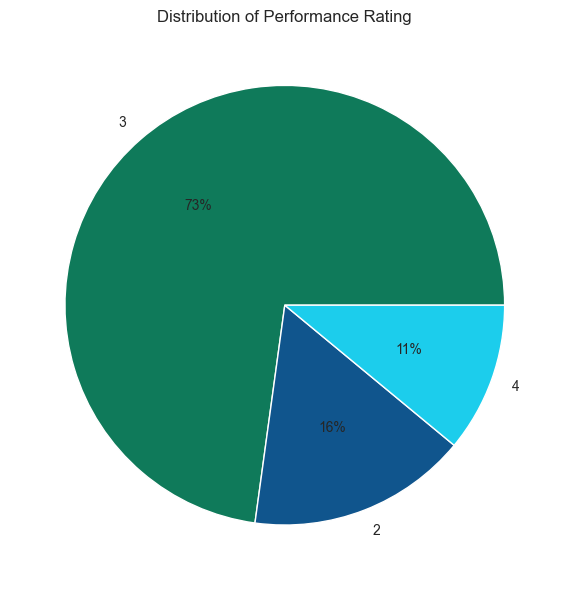

In [16]:
# plot a pie chart for Performance Rating

plt.figure(figsize=(10, 6))

vals = df['PerformanceRating'].value_counts()

plt.pie(vals, labels=vals.index, autopct='%1.0f%%',colors= color)

plt.title('Distribution of Performance Rating')

plt.tight_layout()
plt.show()

**COMMENT**

The target variable (Performance Rating) is imbalanced. Most employees fall under rating 3, which makes up 73% of the dataset meaning that the majority employees are excellent performers. Rating 2 follows with 16%, representing the good/at risk performers, and only 11% of employees are outstanding performers with a rating of 4. This is the distribution of the 1,200 employees:

Rating 3: 874 employees

Rating 2: 194 employees

Rating 4: 132 employees

Because of this imbalance, we will use stratification during modeling to make sure all classes are well-represented in both the training and test sets. SMOTE will not be necessary because we  have enough samples in the minority classes (194 and 132) to train a good model. We will not use accuracy as a method of evaluating our models, instead we will use recall, f1 score and precision which work better with imbalanced data.

### b. Categorical variables

In [17]:
# i will exclude EmpDepartment, EmpJobRole, EducationBackground on this plot because they have too many categories

categorical_features = ['Gender', 'MaritalStatus', 'BusinessTravelFrequency', 'OverTime', 'CommuteCategory',
                         'PromotionWaitTime', 'Attrition']


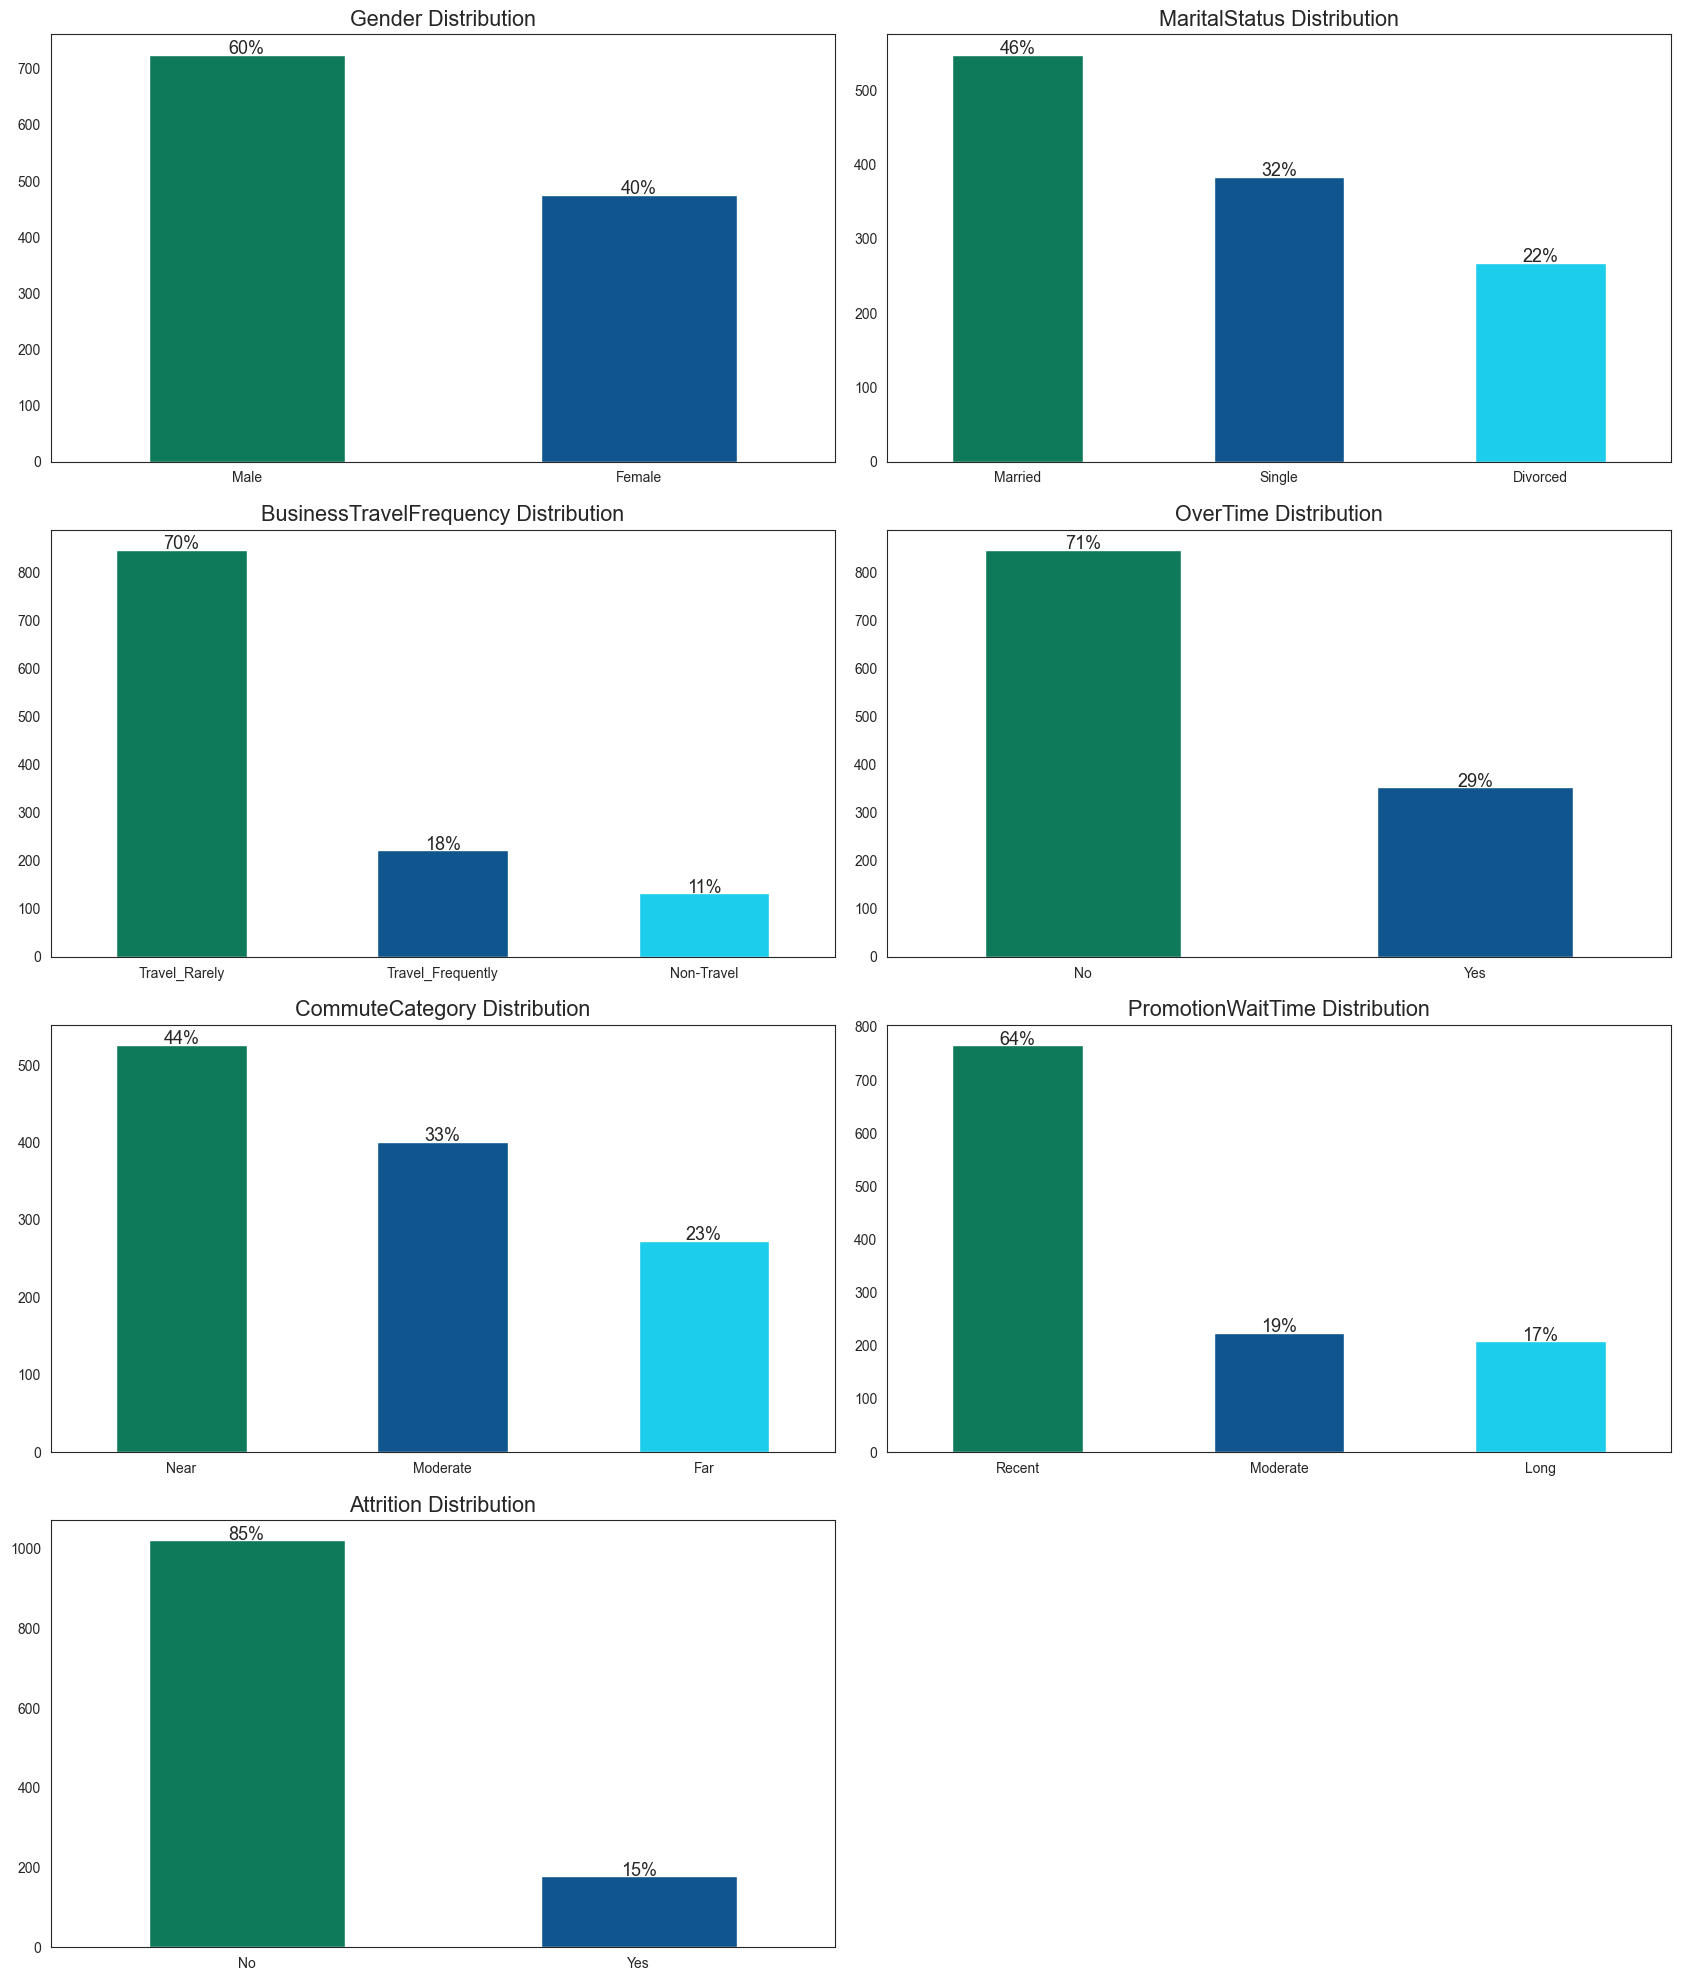

In [18]:
# for graphs to be on the same figure i will create subplots

fig, axes = plt.subplots(4, 2, figsize=(17, 20))
axes = axes.flatten()

plt.rcParams['font.size'] = 13

for idx, col in enumerate(categorical_features):
    # percentages
    vals = df[col].value_counts()
    pct = vals /vals.sum() * 100

    vals.plot(kind='bar', ax=axes[idx], color=color )
    axes[idx].set_title(f"{col} Distribution")
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=0)

    # add percantage labels
    for j, val in enumerate(vals):
        axes[idx].text(j, val + 1, f"{pct.iloc[j]:.0f}%", ha='center')

# delete leftover axes
for ax in axes[len(categorical_features):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


**COMMENT**

- The **gender** column split is a bit uneven, with about 60% male and 40% female. It’s nothing extreme, but it does show the dataset leans slightly toward male employees.

- For **marital status**, most people are married (46%), then single employees at 32%, and divorced at 22%. So the groups are fairly distributed.

- **Business travel** is where the skew really shows. About 70% of employees rarely travel, while 18% travel frequently and  11% don’t travel at all. This tells us that most roles probably don’t require much travelling.

- **Overtime** is also uneven. Around 71% don’t work overtime and 29% do, this means overtime isn’t very common in this workforce.

- **Commute distance** is a bit more balanced. About 44% of employees live near work, 33% have a moderate commute, and 23% travel from farther away.

- **Promotion wait time** : A big portion (64%) fall under “Recent,” while 19% fall under “Moderate” and 17% under “Long.” So most employees have been promoted fairly recently.

- **Attrition** is relatively low. About 85% of employees stayed, while 15% left, indicating that the majority of the workforce is stable, with a smaller but still meaningful portion experiencing turnover.



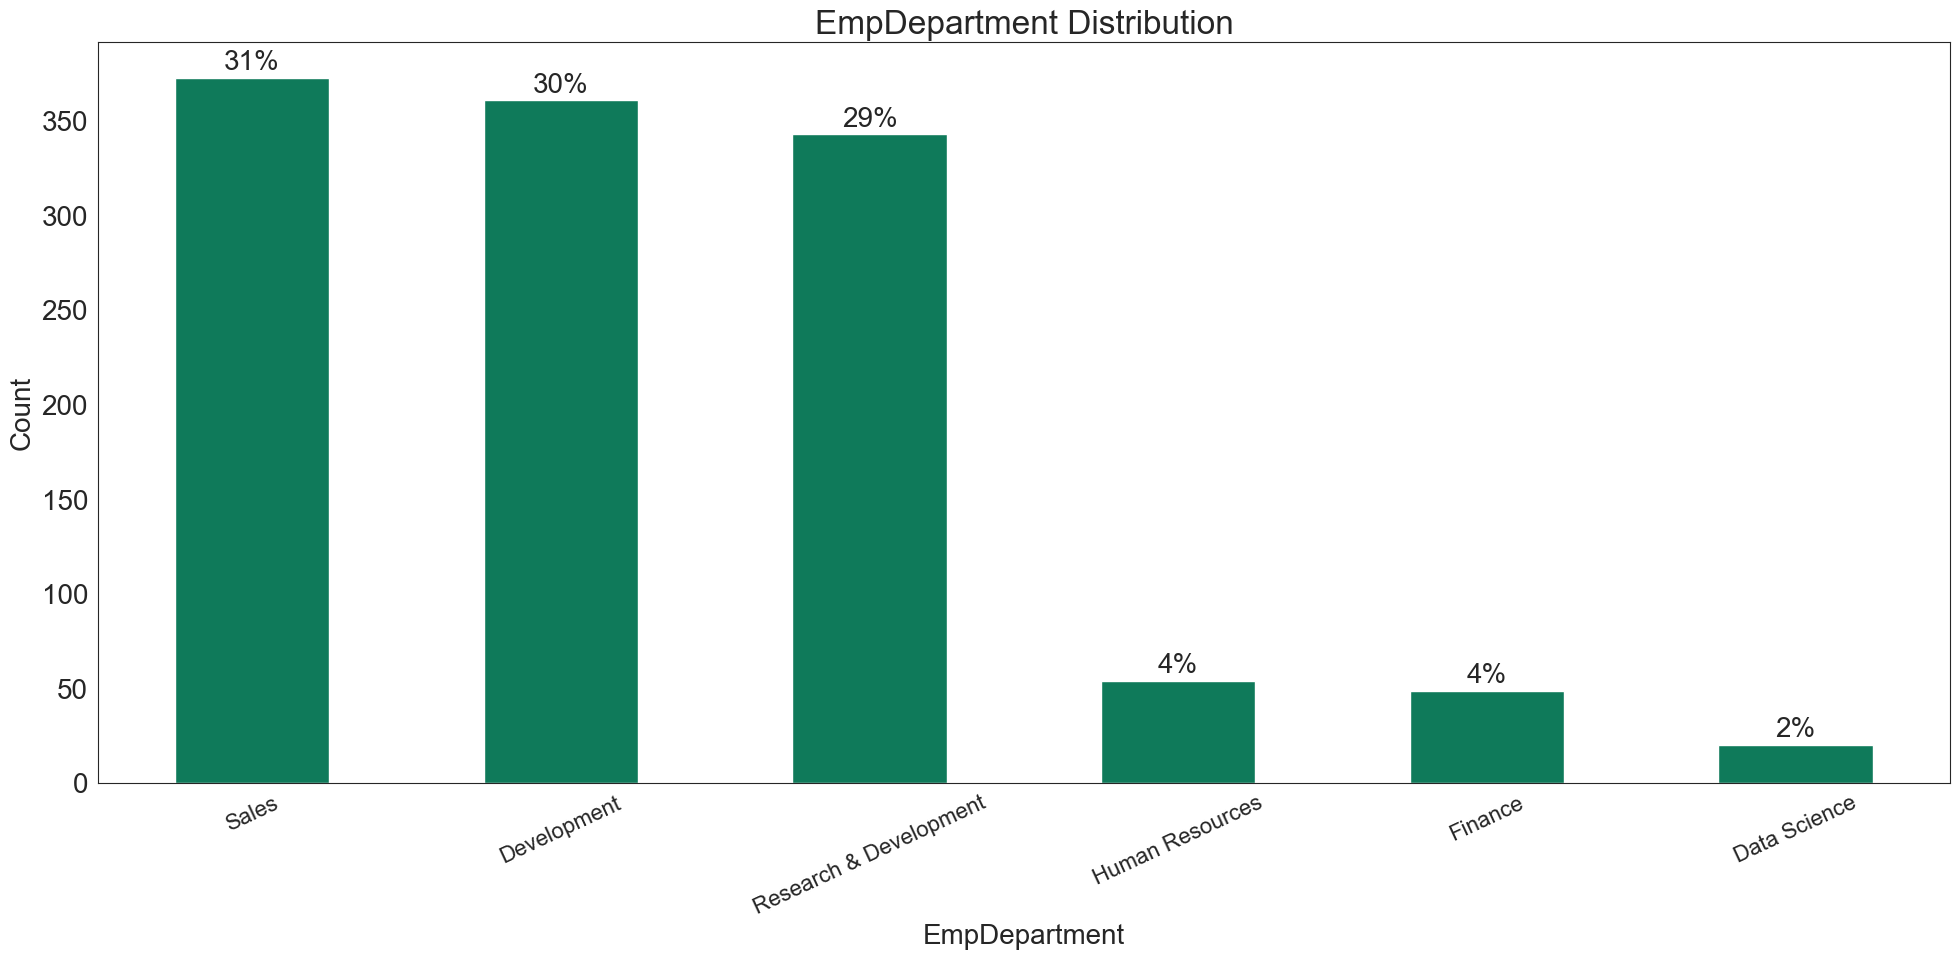

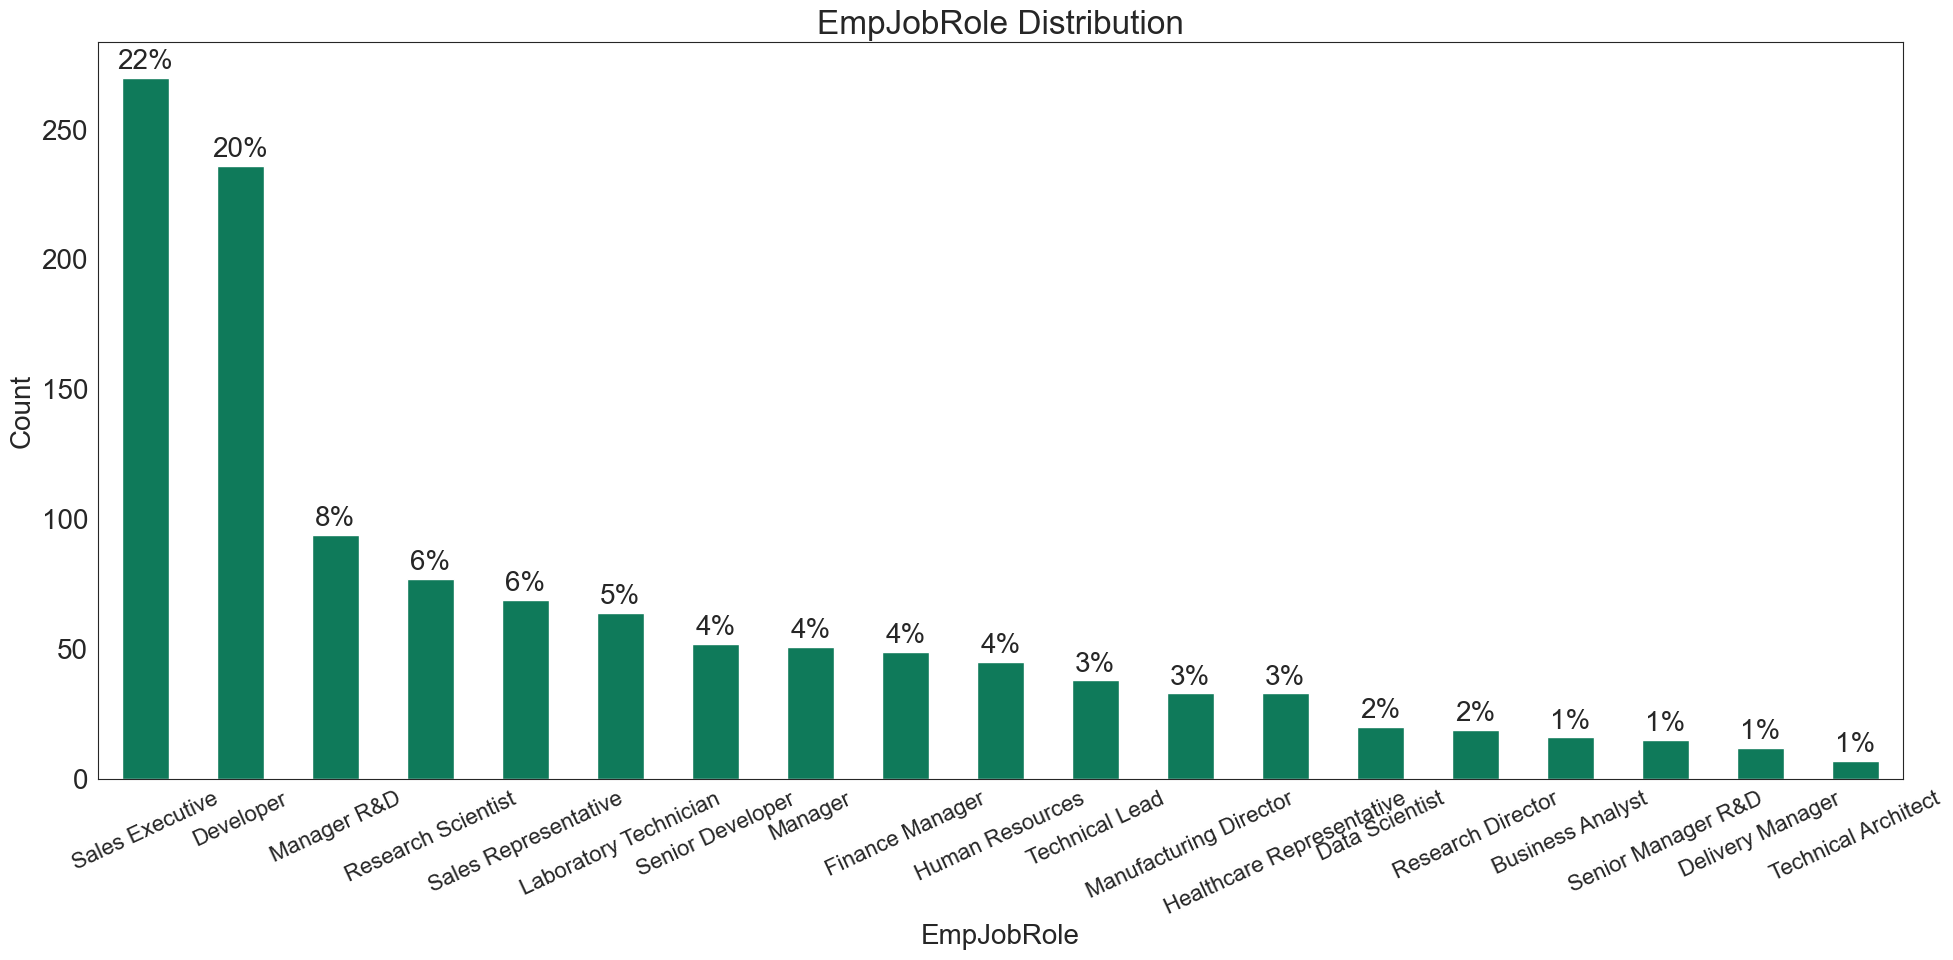

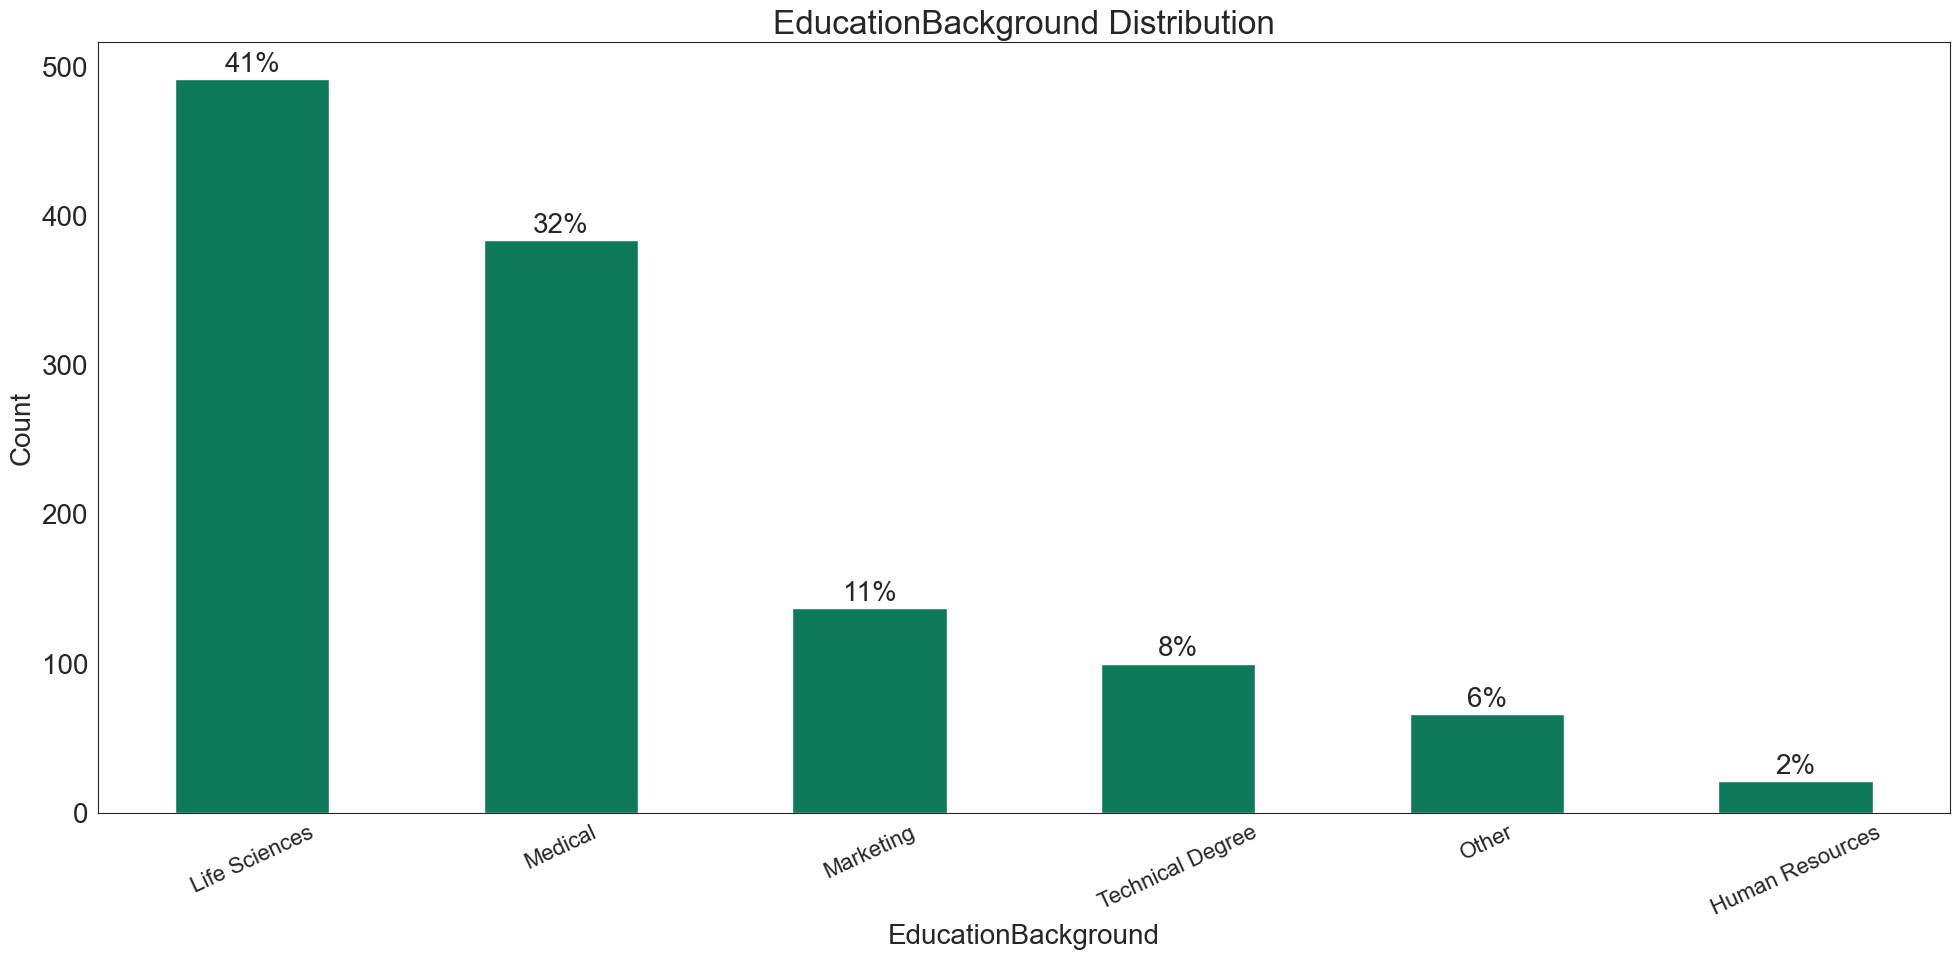

In [19]:
categorical_features2 = ['EmpDepartment', 'EmpJobRole', 'EducationBackground']

plt.rcParams['font.size'] = 20 

for col in categorical_features2:
    #percentages
    vals = df[col].value_counts()
    pct = vals/vals.sum() * 100

    plt.figure(figsize=(20,10))
    vals.plot(kind='bar', color="#0f7a5a")
    plt.title(f"{col} Distribution")
    plt.ylabel("Count")
    plt.xticks(rotation=25, fontsize=16)

    # add percentage labels on top of bars
    for j, val in enumerate(vals):
        plt.text(j, val + 1, f"{pct.iloc[j]:.0f}%", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


**COMMENT**

- The **department** distribution is somewhat balanced across the three major groups. Sales makes up about 31% of employees, Development is close behind at 30%, and R&D follows with 29%. The remaining departments HR, Finance, and Data Science are very small.

- The distribution of **job roles** is much more uneven. There are a few roles, like Sales Executive (22%) and Developer (20%), that make up a large portion of the employees. After those majority roles, the percentages drop sharply, with roles like Manager R&D and Manufacturing Director each taking up smaller slices of the dataset. Many job roles have less than 5% representation, this shows that the workforce is spread across a long list of specialized positions.

- **Education Background** is  skewed toward two major categories. Life Sciences leads with 41% of employees, followed by Medical at 32%. After these two, the numbers drop significantly. Marketing accounts for 11%, Technical Degree for 10%, and the remaining categories make up only a very small portion. We see that most employees come from science-related education paths.

Since these features contain many categories, we will group the smaller ones into an **"Other"** category and apply **target encoding** with smoothing to prevent overfitting and reduce noise and also allow the models to learn patterns more effectively.

### c. Ordinal Features

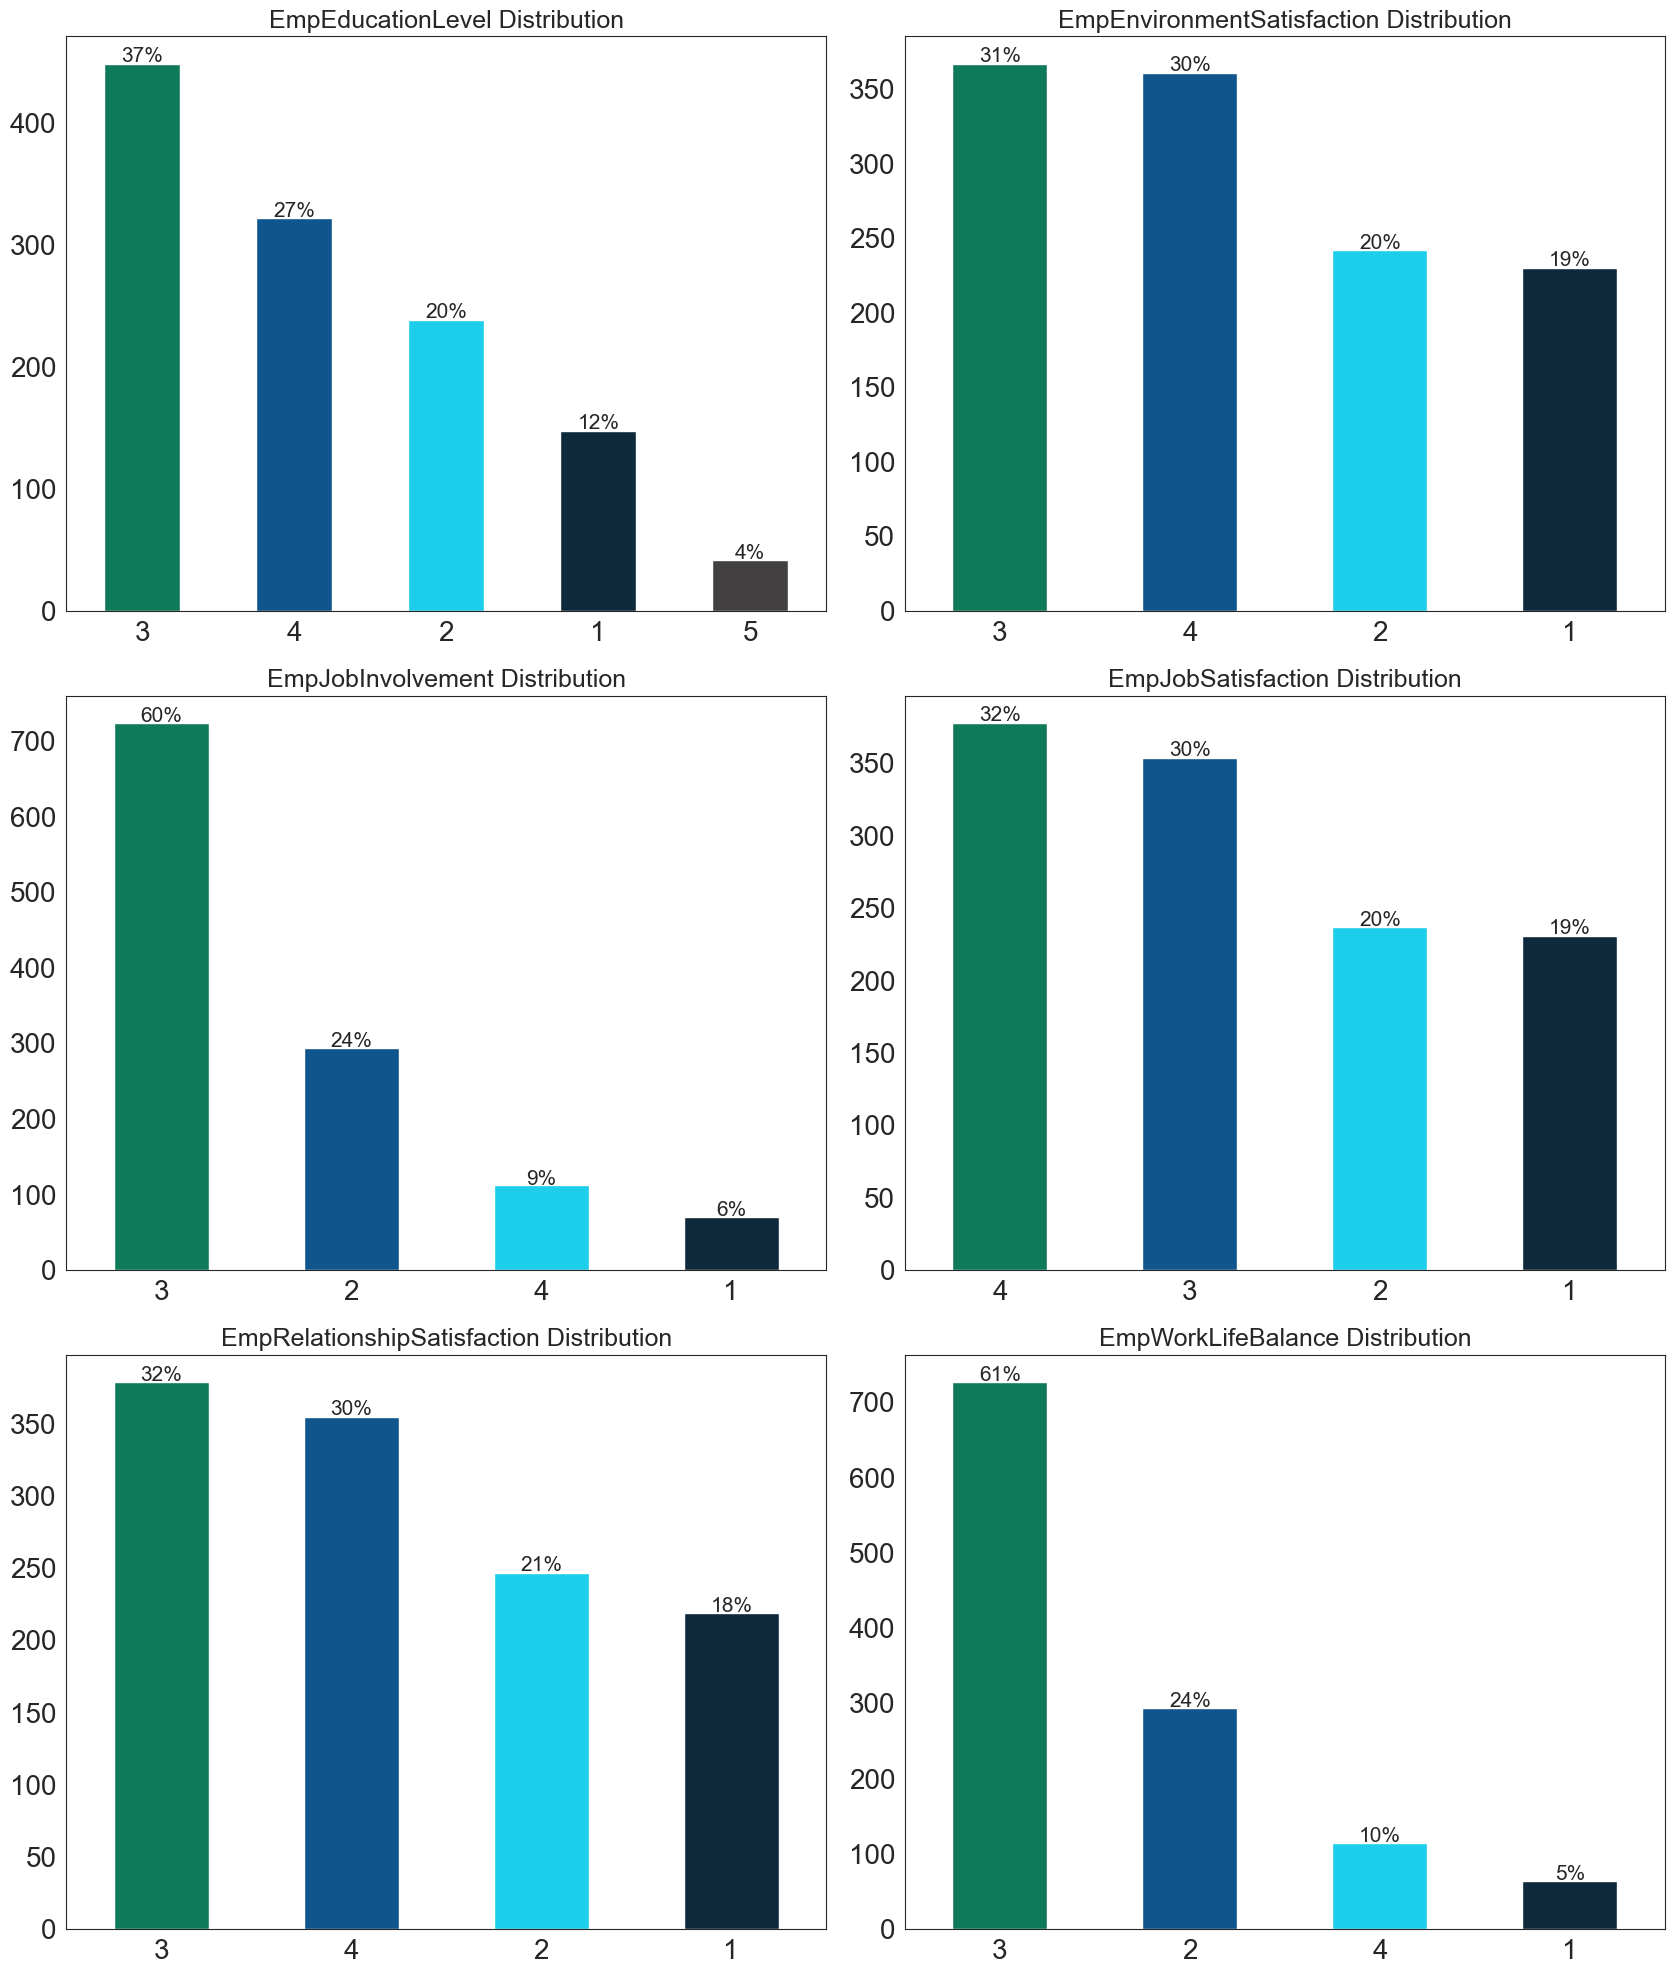

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(17, 20))
axes = axes.flatten()

plt.rcParams['font.size'] = 15

for idx, col in enumerate(ordinal_features):
    # percentages
    vals = df[col].value_counts()
    pct = vals /vals.sum() * 100

    vals.plot(kind='bar', ax=axes[idx], color= colors )
    axes[idx].set_title(f"{col} Distribution")
    axes[idx].set_xlabel("")
    axes[idx].tick_params(axis='x', rotation=0)

    # add percentage labels
    for j, v in enumerate(vals):
        axes[idx].text(j, v + 1, f"{pct.iloc[j]:.0f}%", ha='center')

plt.tight_layout()
plt.show()


**COMMENT**

- In **Education Level**  37% of employees hold a Bachelor's degree and 27% have a Master's. On the extremes, 4% have a PhD, while 12% have education below college. This shows that most employees have mid-range education levels.

- **Environment Satisfaction** is fairly balanced. High and very high satisfied employees account for 31% and 30% of all employees, while low and medium satisfaction make up the rest. This indicates that most employees feel moderately to very satisfied with their work environment.

- **Job Involvement** is skewed toward higher engagement. 60% of employees report high involvement, 34% have medium involvement, and only 6% show low engagement showing that the majority of employees are actively engaged in their work.

- **Job Satisfaction** leans toward higher satisfaction. 62% of employees report high satisfaction with their jobs, while medium to low satisfaction is less common. Overall, most employees feel satisfied and content in their roles.

- **Relationship Satisfaction**: 32% of employees report good relationships and 30% report very good relationships with colleagues. The smaller portions report fair or poor relationships. This means most employees have maintained positive interactions at work.

- **Work-Life Balance** :61% of employees report a balanced work-life situation. There are few who report poor balance, and only a small percentage report excellent balance. This shows that most employees feel they manage their work and personal life reasonably well.

### iii.Numerical Features

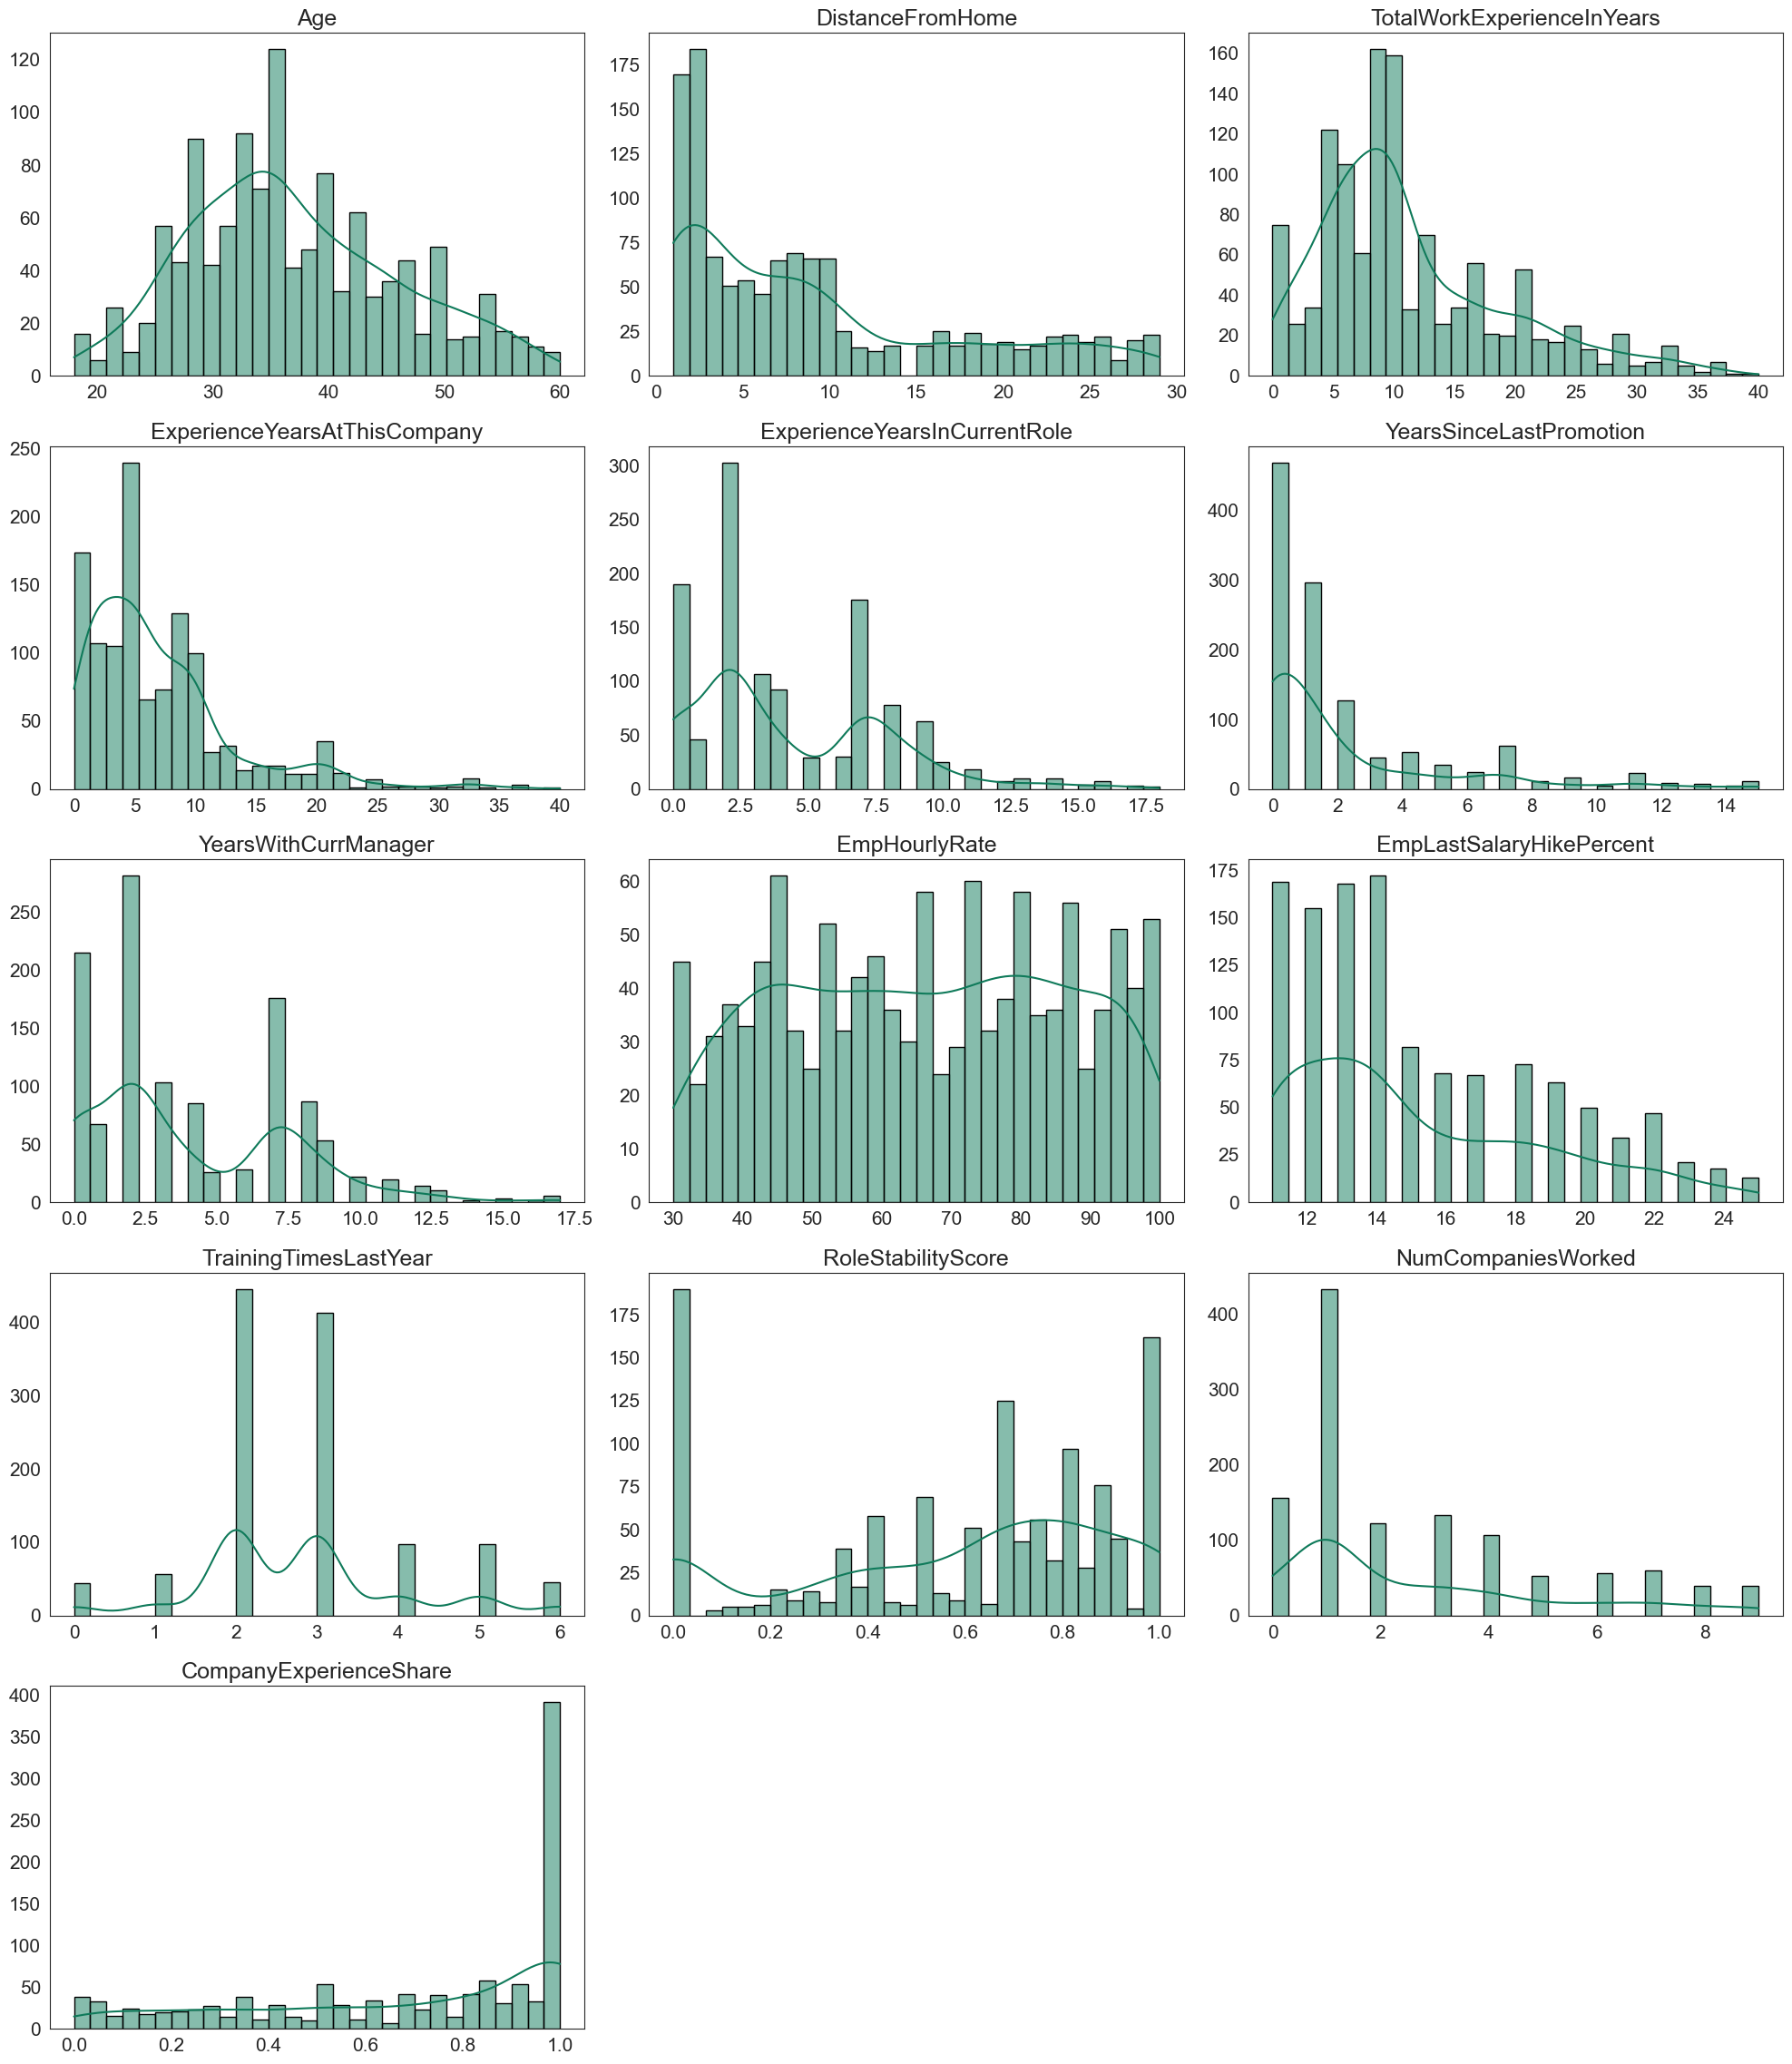

In [21]:
# histogram plots for numerical features
plt.figure(figsize=(20, 23))

for idx, col in enumerate(numerical_features):
    plt.subplot(5, 3, idx + 1)
    sns.histplot(df[col], bins=30, kde=True, color="#0f7a5a", edgecolor='black')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

plt.show()

**Right-Skewed Features**  
- `Age`, `DistanceFromHome`, `TotalWorkExperienceInYears`, `ExperienceYearsAtThisCompany`, `ExperienceYearsInCurrentRole`, `YearsSinceLastPromotion`, `YearsWithCurrManager`, `NumCompaniesWorked` , `EmpLastSalaryHikePercent`
These features are mostly right-skewed, meaning most employees are younger, have shorter commutes, and less experience. Promotions seem to be more recent for the majority. Also there are a few outliers with long tenure, higher experience, or longer commutes, which may represent senior or long-serving employees.

**Bimodal / Multi-Peaked Features**  
- `EmpHourlyRate`, `TrainingTimesLastYear`, `RoleStabilityScore`  
These features show two or more different peaks. For example, hourly rate may separate junior and senior roles, and training times often cluster at 0, 2 and 7 showing natural groups within the workforce while highlighting the differences that could be meaningful for analysis.

**Left-Skewed Features**  
- `CompanyExperienceShare`  
Simply put many employees have spent a large portion of their career at the current company, with only a few having split their experience across multiple companies. This shows a generally stable workforce with limited job-hopping.

**NB:** 

Since the primary models are tree-based, there will be no transformations applied, as they are able to handle skewed and non-normal distributions naturally. The only preprocessing step on these numerical features will be scaling for the baseline multinomial Logistic Regression model, which benefits from scaled data. However the two tree-based models will be trained on the original, unscaled data.

### **b. Bivariate Analysis**

### i. Performance across Departments

EmpDepartment
Sales                     373
Development               361
Research & Development    343
Human Resources            54
Finance                    49
Data Science               20
Name: count, dtype: int64


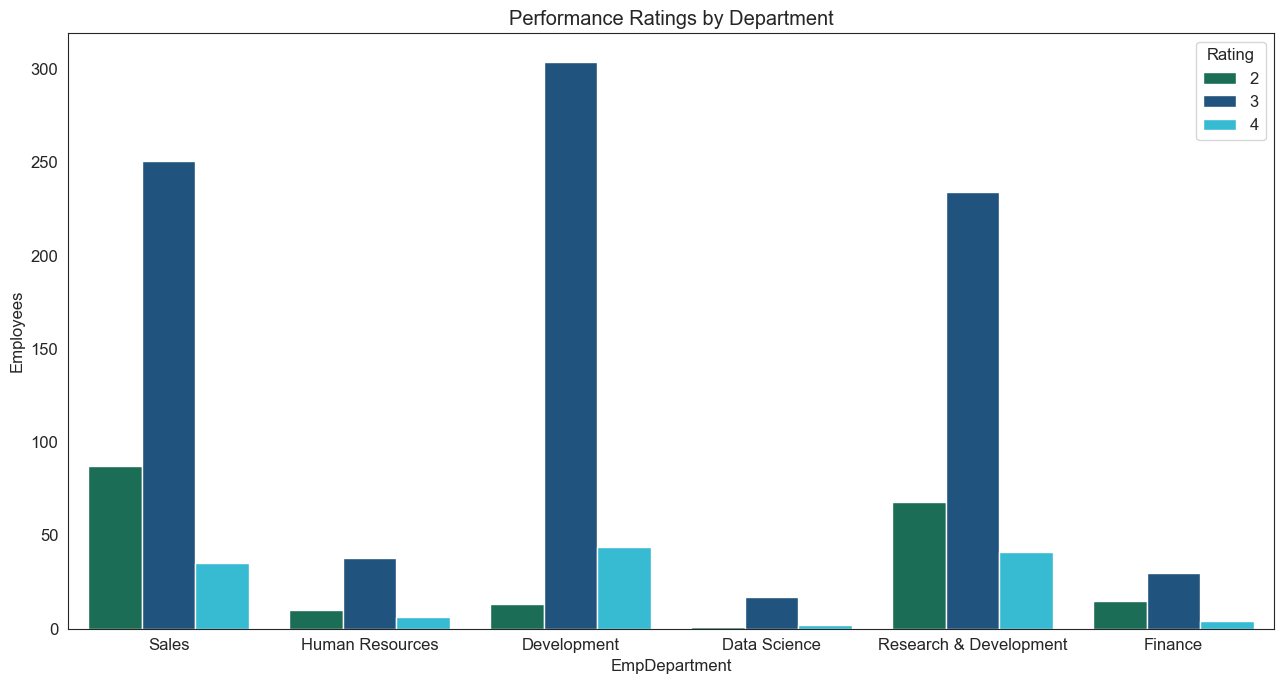

In [22]:
# Let's print the total employees per department
vals = df['EmpDepartment'].value_counts()
pct = (vals/vals.sum()) *100

print(vals)

plt.rcParams['font.size']= 12

plt.figure(figsize=(13,7))
sns.countplot(data=df, x='EmpDepartment', hue='PerformanceRating',
             palette= color)
plt.title("Performance Ratings by Department")
plt.ylabel("Employees")

plt.legend(title="Rating")
plt.tight_layout()
plt.show()

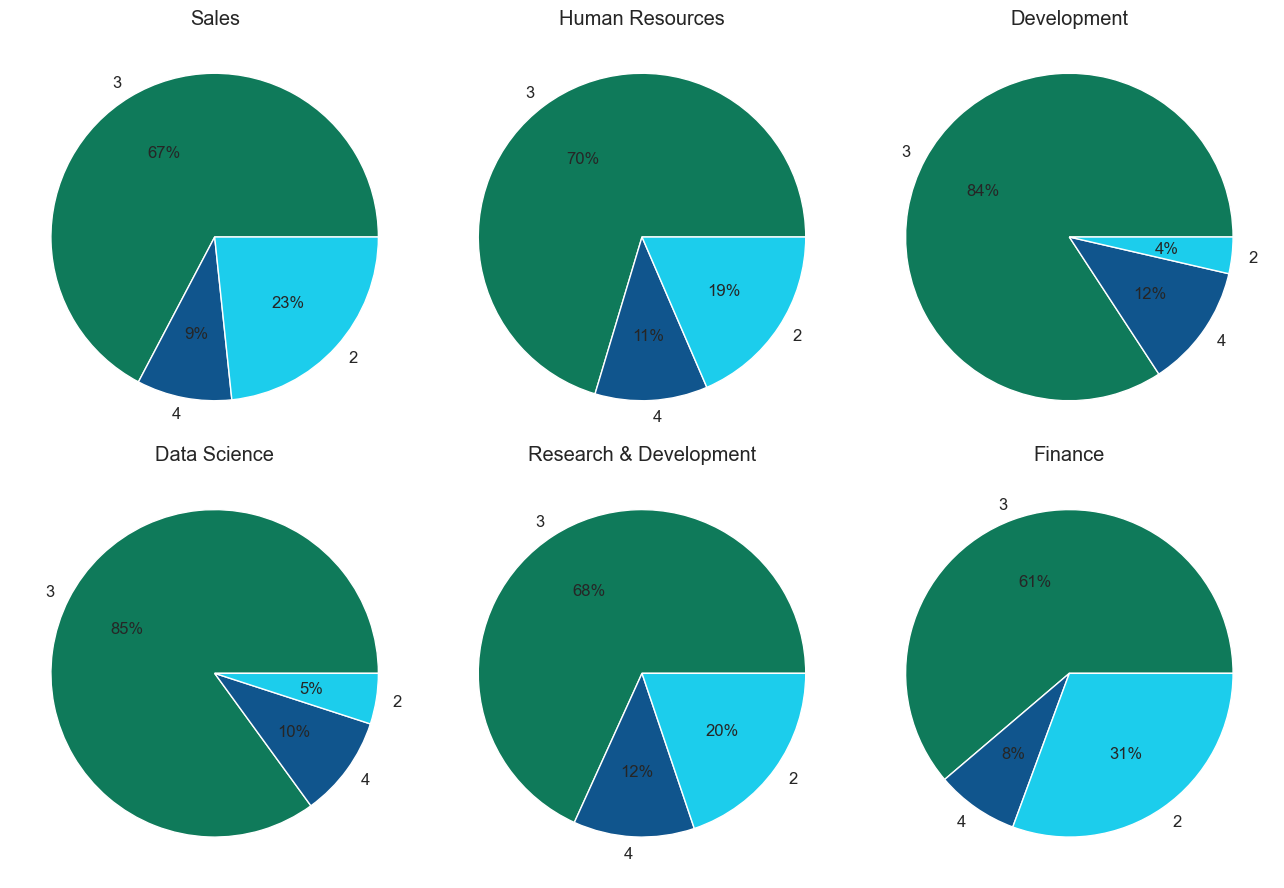

In [23]:
departments = df['EmpDepartment'].unique()
ratings = df['PerformanceRating'].unique()

plt.figure(figsize=(13, 9))

for idx, col in enumerate(departments):
    plt.subplot(2, 3, idx + 1)
    tmp =df[df['EmpDepartment'] == col]
    vals= tmp['PerformanceRating'].value_counts().reindex(ratings, fill_value=0)

    plt.pie(vals,labels=vals.index, 
            autopct=lambda p: f"{p:.0f}%" if p > 0 else "",
            colors= color)
        
    plt.title(col)

plt.tight_layout()
plt.show()


**COMMENT**

### **Best Performing Departments**
- **Development:** As the second-largest team (361 employees), Development shows consistently strong results. Only 4% are rated 2, while 12% reached the top rating, with the majority performing at an “excellent” level. This department stands out and should be maintained as a benchmark for best practices.
-**Data Science:** Although it is small (20 employees), Data Science performs remarkably well. Only 5% are rated 2, and 10% achieved the outstanding rating, and with most rated “excellent.” This team shows very good efficiency. It could be used to mentor or influence other departments.

### **Moderate-Performing Departments**

- **Research & Development**  has 343 employees. R&D looks steady and reliable. About 20% are rated 2, and 12% reached the top rating, while most fall into the “excellent” category. The focus should be on moving more employees into the top performance tier.
- **HR:** With 54 employees it shows consistent performance, where 19% are rated 2 and 11% at the top level. A similar development approach as R&D would be effective here.
- **Sales** is the largest department (373 employees). While most are rated “excellent,” 23% are still at 2, and only 9% reach the top. Development programs could help increase top performers and reward outstanding performers.

### **Least Performing Department**

- **Finance**: With 49 employees, Finance has the highest share of lower ratings (31%) and only 8% top performers. While most employees are rated 3, this department needs focused support and interventions to raise overall performance. 


### ii. Relationship between categorical features and Performance Rating

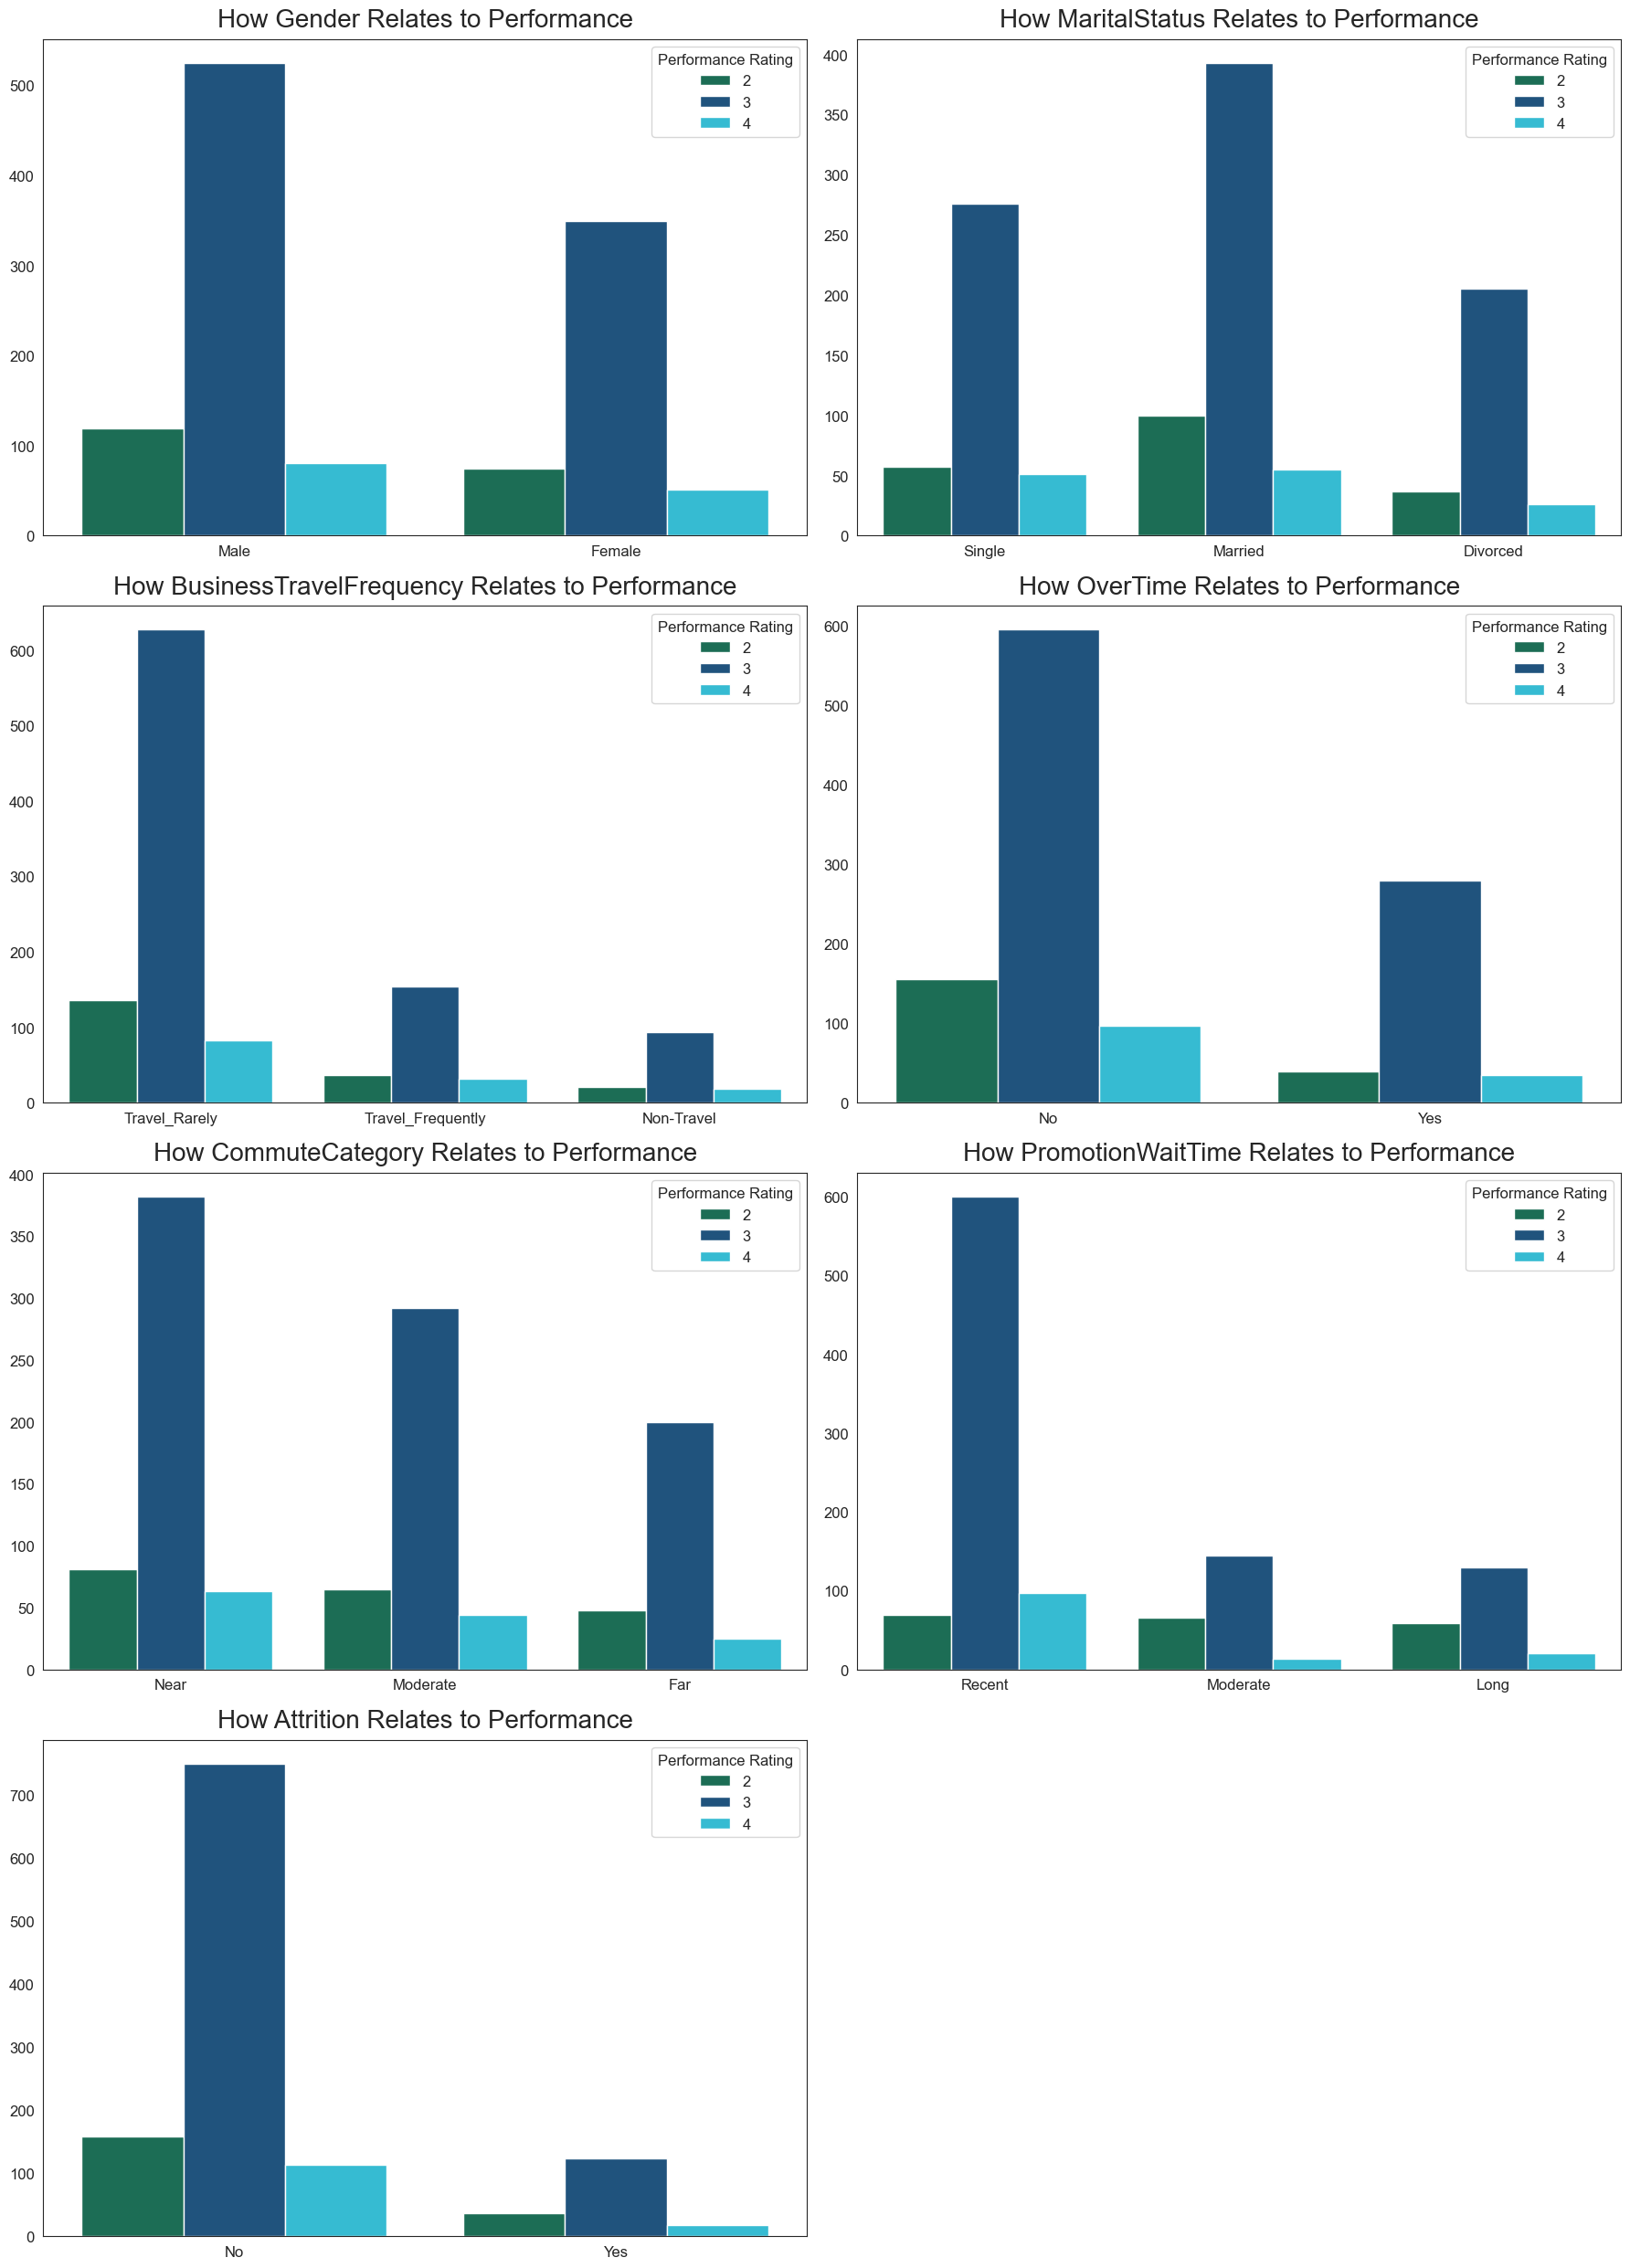

In [24]:
# plot the relationship between categorical features and Performance Rating
plt.figure(figsize=(18, 25))

for idx, col in enumerate(categorical_features, 1):

    plt.subplot(4, 2, idx)
    sns.countplot(data=df, x=col, hue='PerformanceRating', palette=color)
    plt.title(f'How {col} Relates to Performance', fontsize=20, pad=10)
    plt.ylabel("")
    plt.xlabel("")
    plt.gca().legend(title='Performance Rating')

plt.tight_layout()
plt.show()


**COMMENT**

- Performance based on **Gender** is similar for men and women. Around 83% of males and 87% of females are rated solid (3), while top performers (4) are equally low for both groups. This shows that gender does not really affect performance.

- **Marital status** has minimal impact on employee performance. Employees who are married, single, or divorced all show similar distributions of performance. The majority is rated (3) and only a small portion is rated high (4). So this also is not a strong indicator of performance.

- **Business Travel frequency** also does not drive performance. Most employees rarely travel, and their performance is similar to that of frequent travelers. Travel frequency does not indicate higher performance.

- Working **overtime** also is not a strong indicator of performance. The employees who work overtime and those who don't have a similar distribution.

- **Commute distance** has very little influence on performance. Employees  who live near, moderately far, or far from work have similar distributions in proportion to their sizes.I would suggest we focus more on job design and environment instead of commute distance of employees.

- **Promotion timing**  is a good indicator of performance. Employees who have been promoted recently have more top performers (3 & 4), while those waiting longer have less. Promotion cycles should be reviewed and they should provide targeted career development for those waiting too long.

- Performance based on **Attrition** looks similar for those who are existing and the attrited. The distributions of performance rating seem to have similar distributions in proportions to their sizes.Though attrition is a strong early warning sign of disengagement.


### iii. relationship between ordinal features and Performance Rating

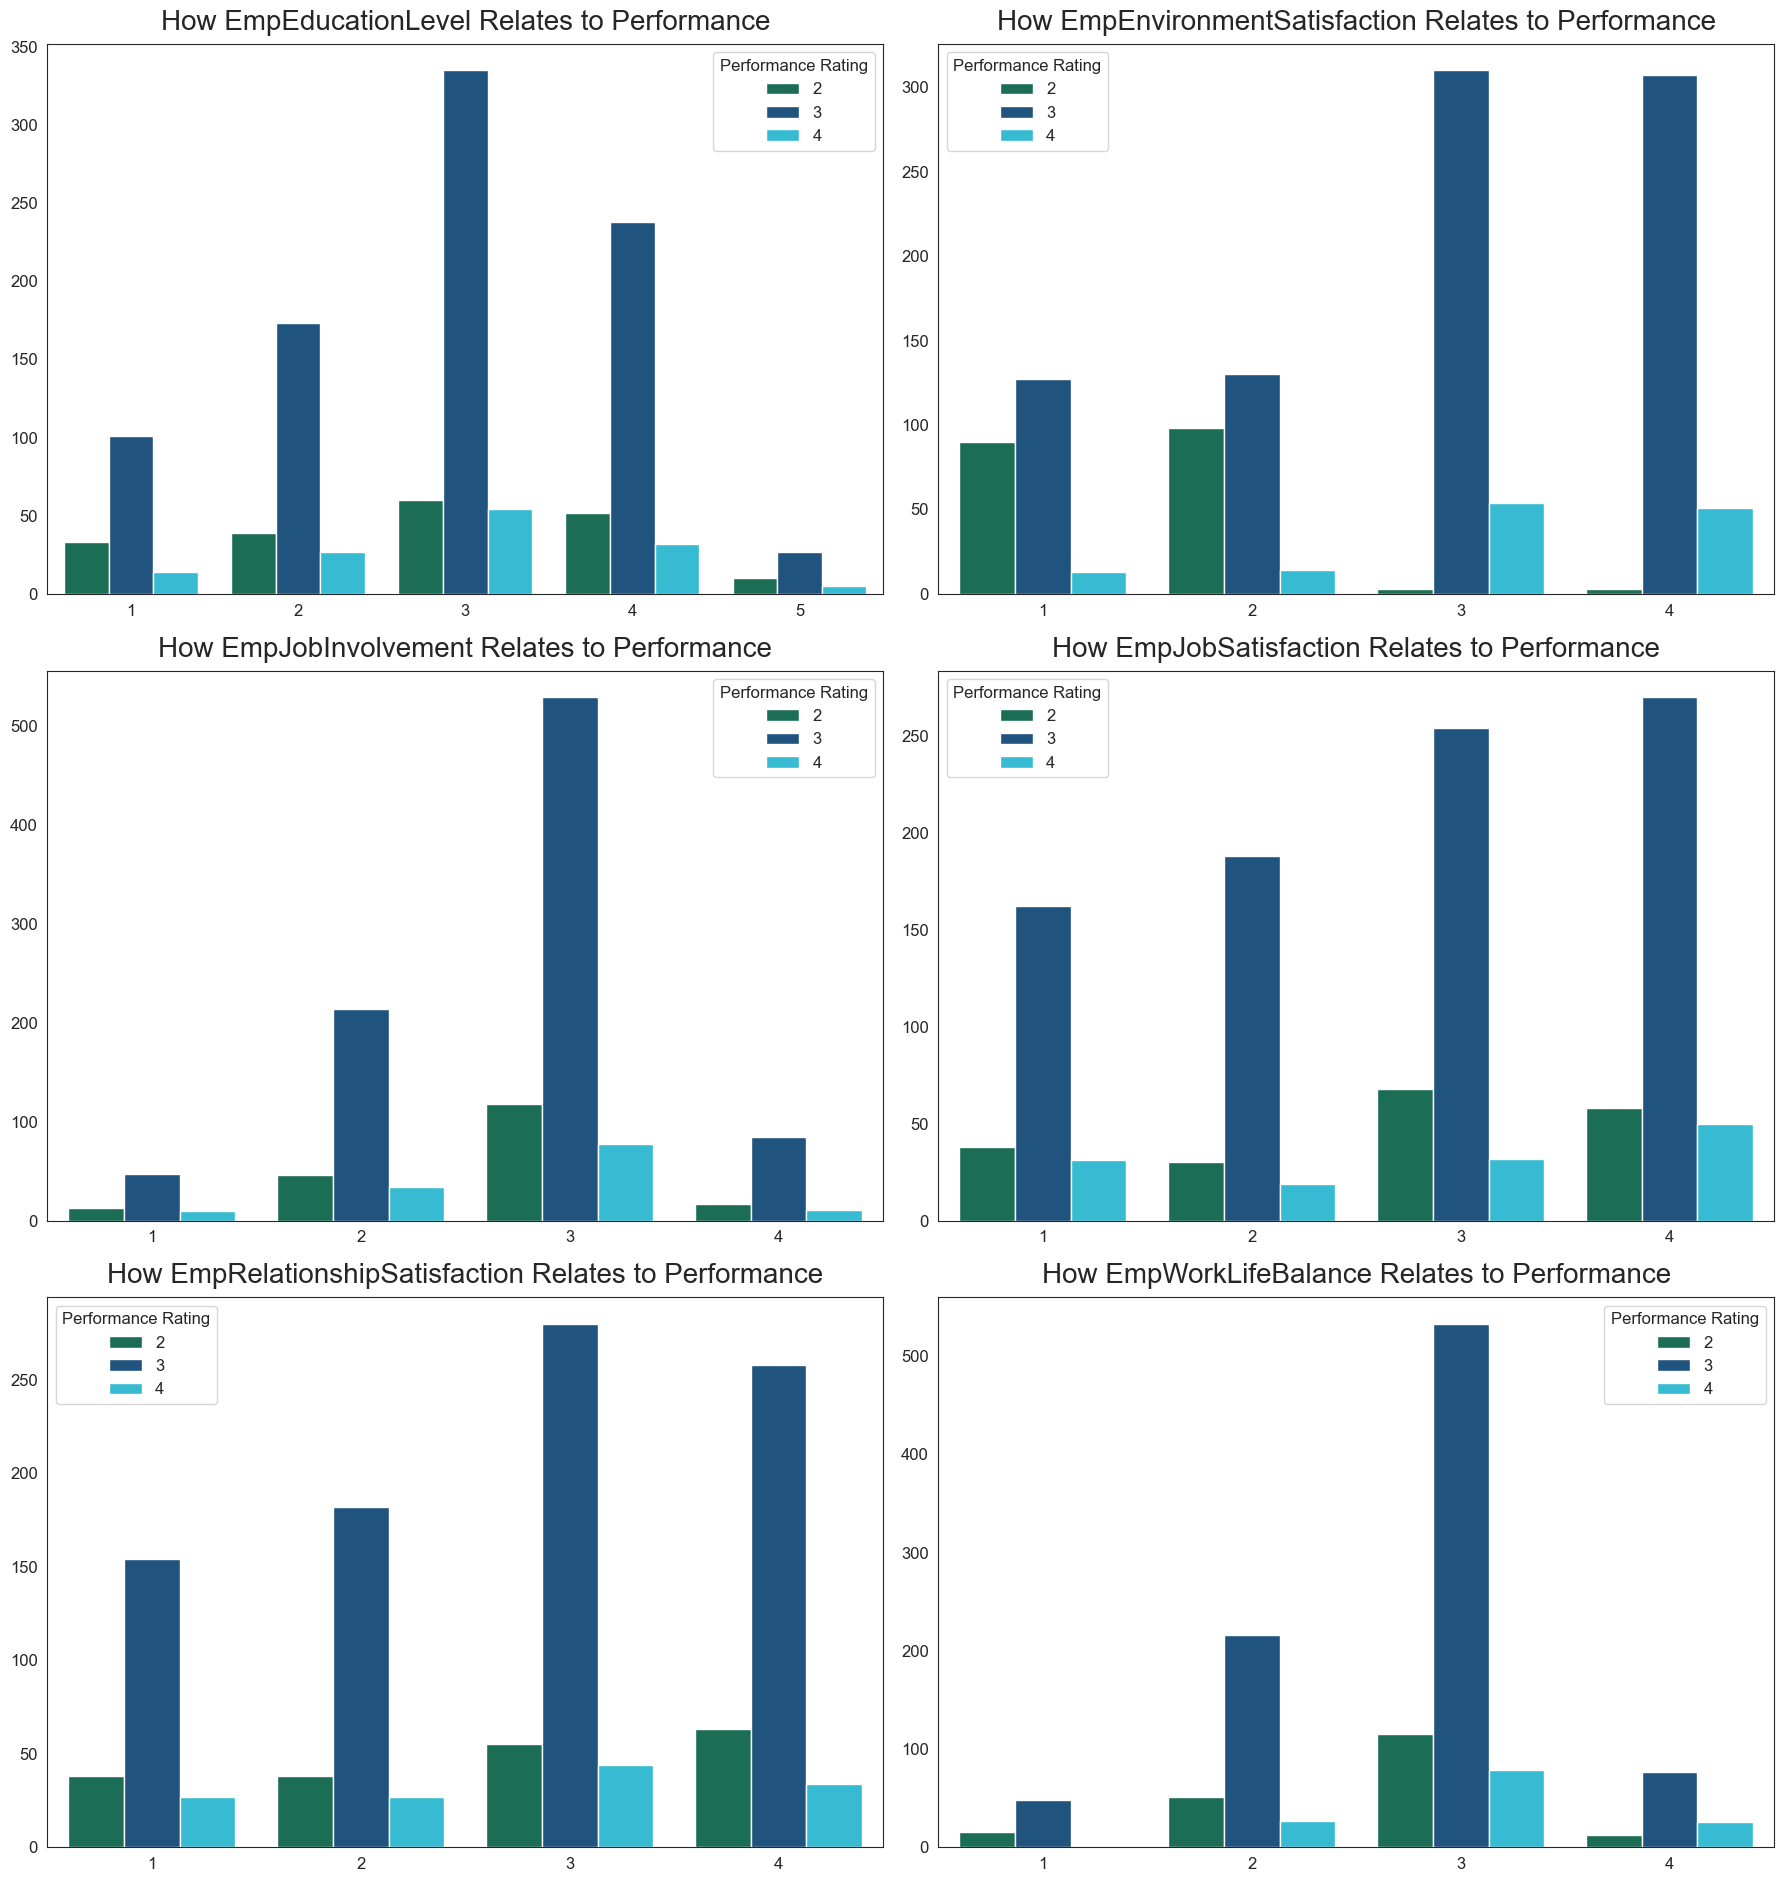

In [25]:
# plot the relationship between ordinal features and Performance Rating
plt.figure(figsize=(18, 25))

for idx, col in enumerate(ordinal_features, 1):

    plt.subplot(4, 2, idx)
    sns.countplot(data=df, x= col, hue='PerformanceRating', palette=color)
    plt.title(f'How {col} Relates to Performance', fontsize=20, pad=10)
    plt.ylabel("")
    plt.xlabel("")
    plt.gca().legend(title='Performance Rating')

plt.tight_layout()
plt.show()


**COMMENT**

- Performance does not show any drastic changes depending on **education level**. Across all the levels of education, the majority of employees have a rating 3. This shows that the formal qualifications strong indicators of workplace performance.

- A positive **work environment** looks to be strongly associated with better performance. As environment satisfaction increases, the number of top performers (Rating 4) increases noticeably and the rating 2 drops drastically. This is one of the clearest drivers of high performance.

- Employees who are more involved in their work consistently perform better. Higher **job involvement** relates to higher performance though not so strongly, though this highlights the importance of engagement in driving results.

- **Job satisfaction** has a weak positive relationship with performance. Employees who report higher satisfaction levels are  more likely to receive Ratings 3 and 4 than those who are dissatisfied though on the graph we see there are dissatisfied employees who are outstanding.

- Relationship Satisfaction does not strongly correlate to stronger performance. Though i would argue that employees who report better relationships with colleagues and managers tend to fall more often into the higher performance categories.

- Work-life balance does have a positive effect on performance, but it is less influential than factors like engagement and environment. Employees with good balance perform well, but it is not the primary driver of top ratings.

Now let's observe our numeric features


### iv. Relationship between numerical features and Performance Rating

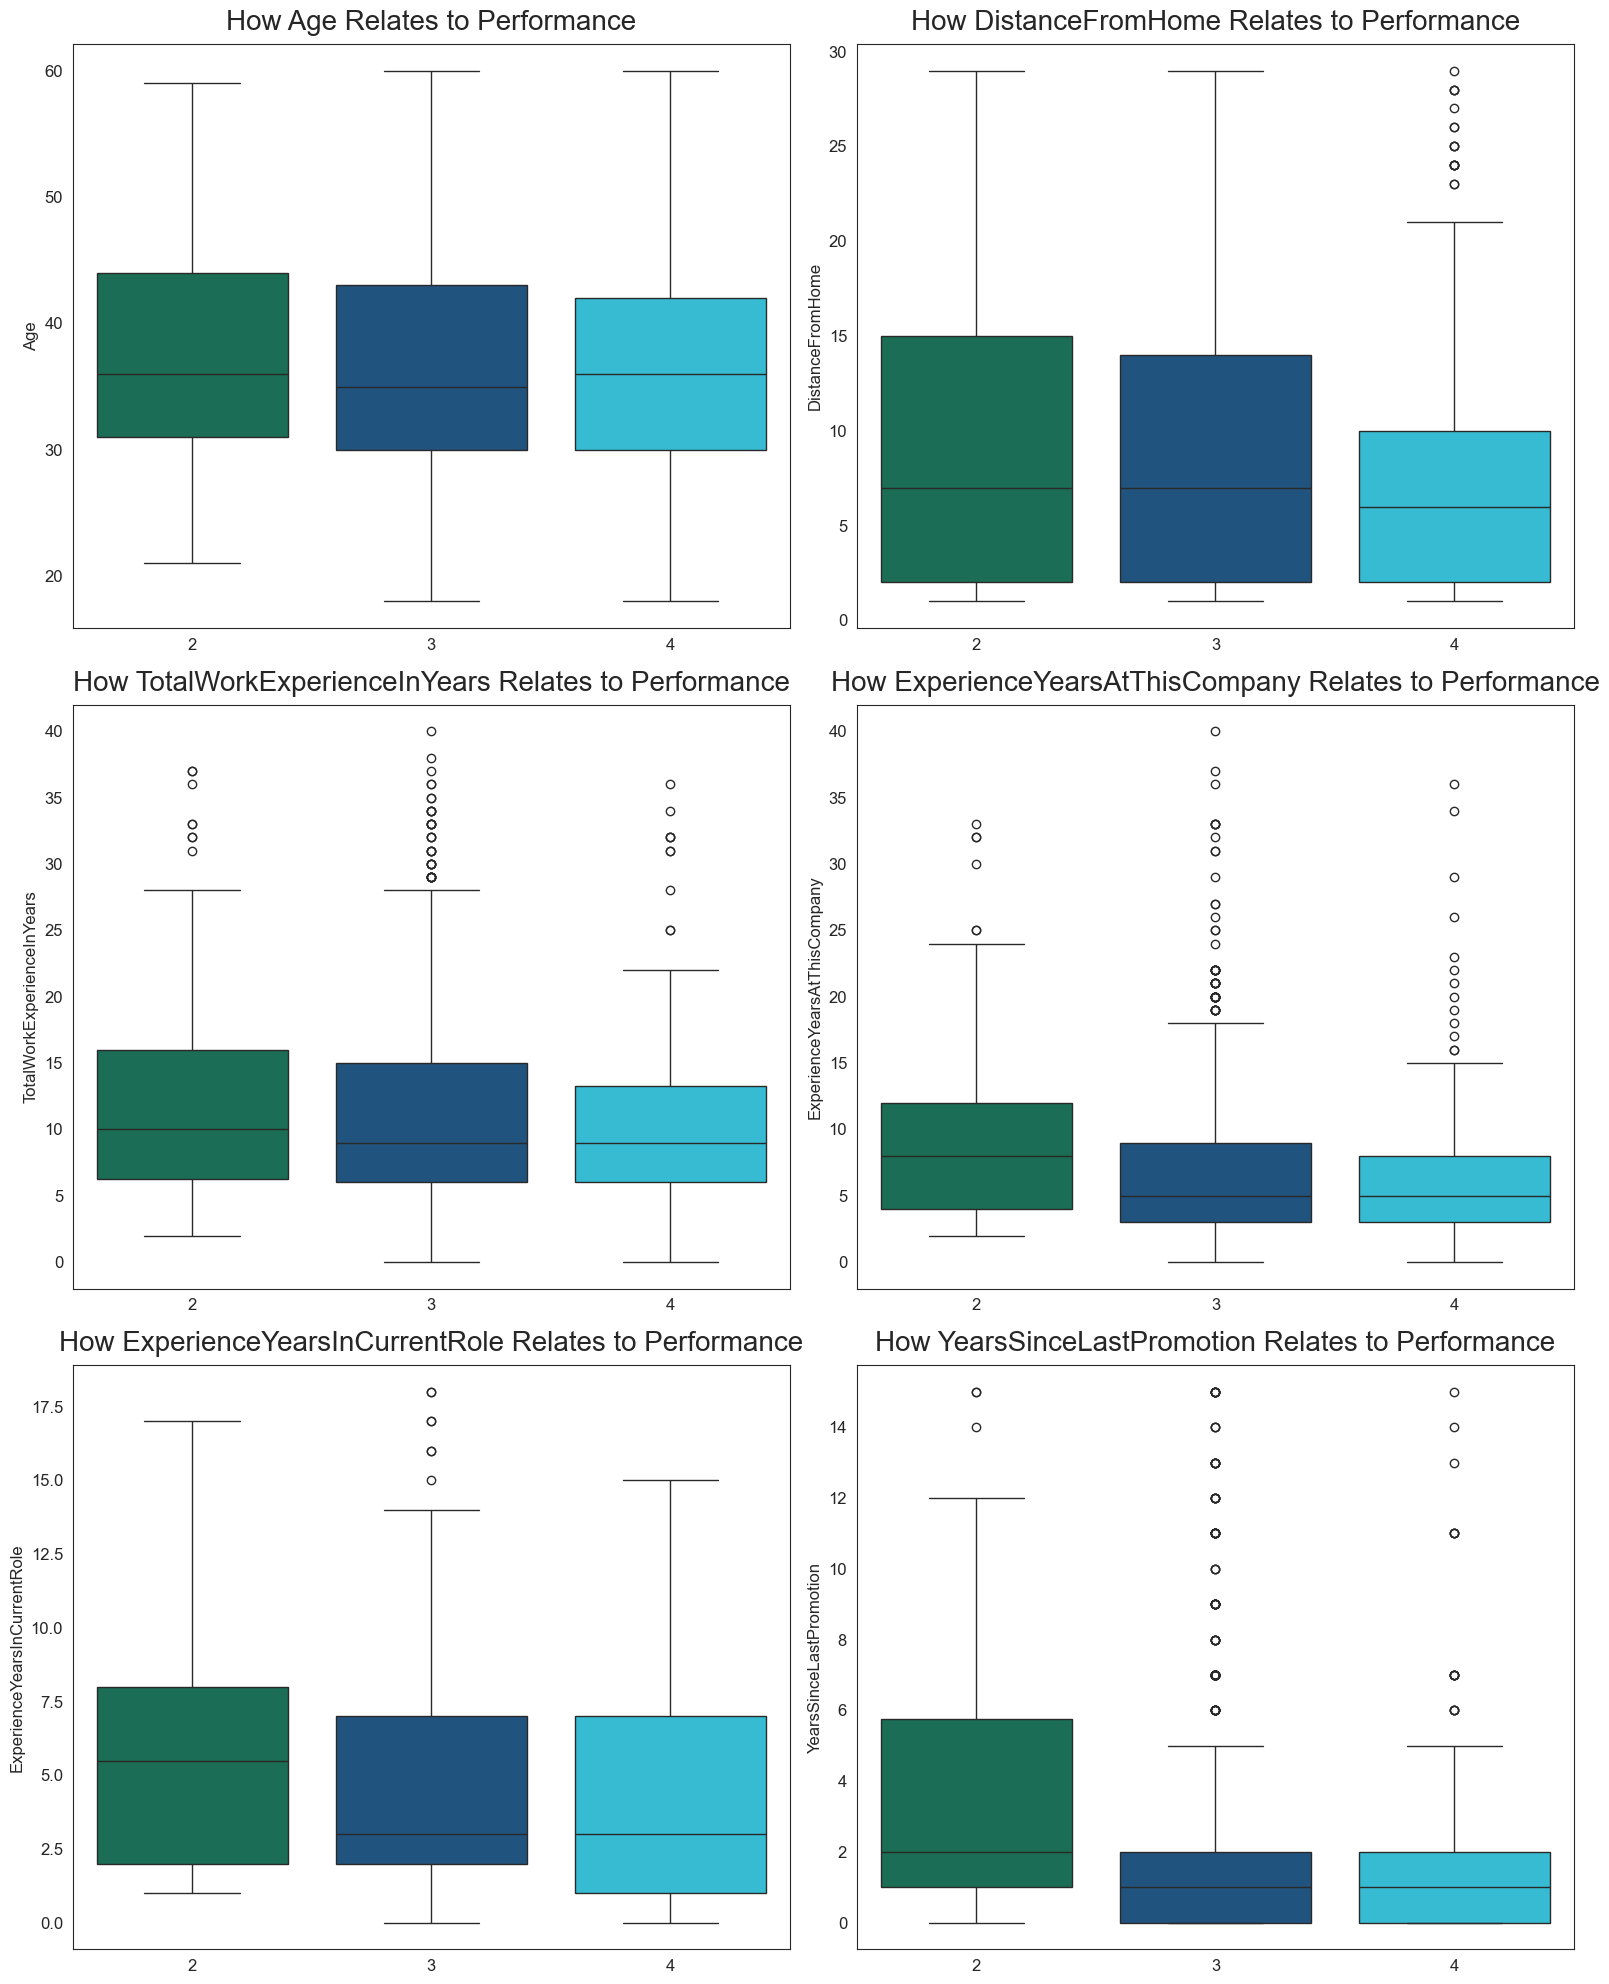

In [26]:
# plot the relationship between numerical features and Performance Rating
plt.figure(figsize=(16, 20))
# first 6 features
for i, col in enumerate(numerical_features[:6], 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x='PerformanceRating', y=col, palette=color)
    plt.xlabel("")
    plt.title(f'How {col} Relates to Performance', fontsize=20, pad=10)

plt.tight_layout()
plt.show()

**COMMENT**

- **Age** doesn’t strongly predict performance, employees of all ages seem to perform similarly. The box plots look similar with just small differences. There are no outliers and we see there are a few younger (20s) and older (50s+) employees who are performing well with no age bias.

- **Commute distance** shows little  impact on employee performance, though most employees regardless of how far they live  performing at a similar level. By observing the outliers in rating 4 we see that few employees with long commutes still perform well which suggests commute isn’t really a barrier to success.

- **Total years of experience** alone does not clearly distinguish the performance levels because all three performance groups show similar box heights with overlapping ranges with rating 4 being the smallest. There are many high-experience outliers in all performance groups, which reinforces that experience is not a strong indicator of Performance.

- **Experience Years** at INX shows only a slight upward shift in median with increasing performance, though the box plots still overlap heavily. Employees with long experiences appear in both the lowest and highest performance groups, indicating that time at the company does not guarantee stronger performance.

- The distributions for **Experience in current role** are very similar across all performance ratings, with only a small rise in median for higher performers. we also see that some employees with very short time in role still fall into the top performance category, showing that high performance does not come with experience.

- **Years Since Last Promotion** clearly separates performance groups. We have low performers showing longer promotion wait times. This is seen by the rating 2 box plot that shows a higher median and wider spread. While there are few long wait outliers that still appear among top performers, the overall pattern shows that recent promotion translates to higher performance.


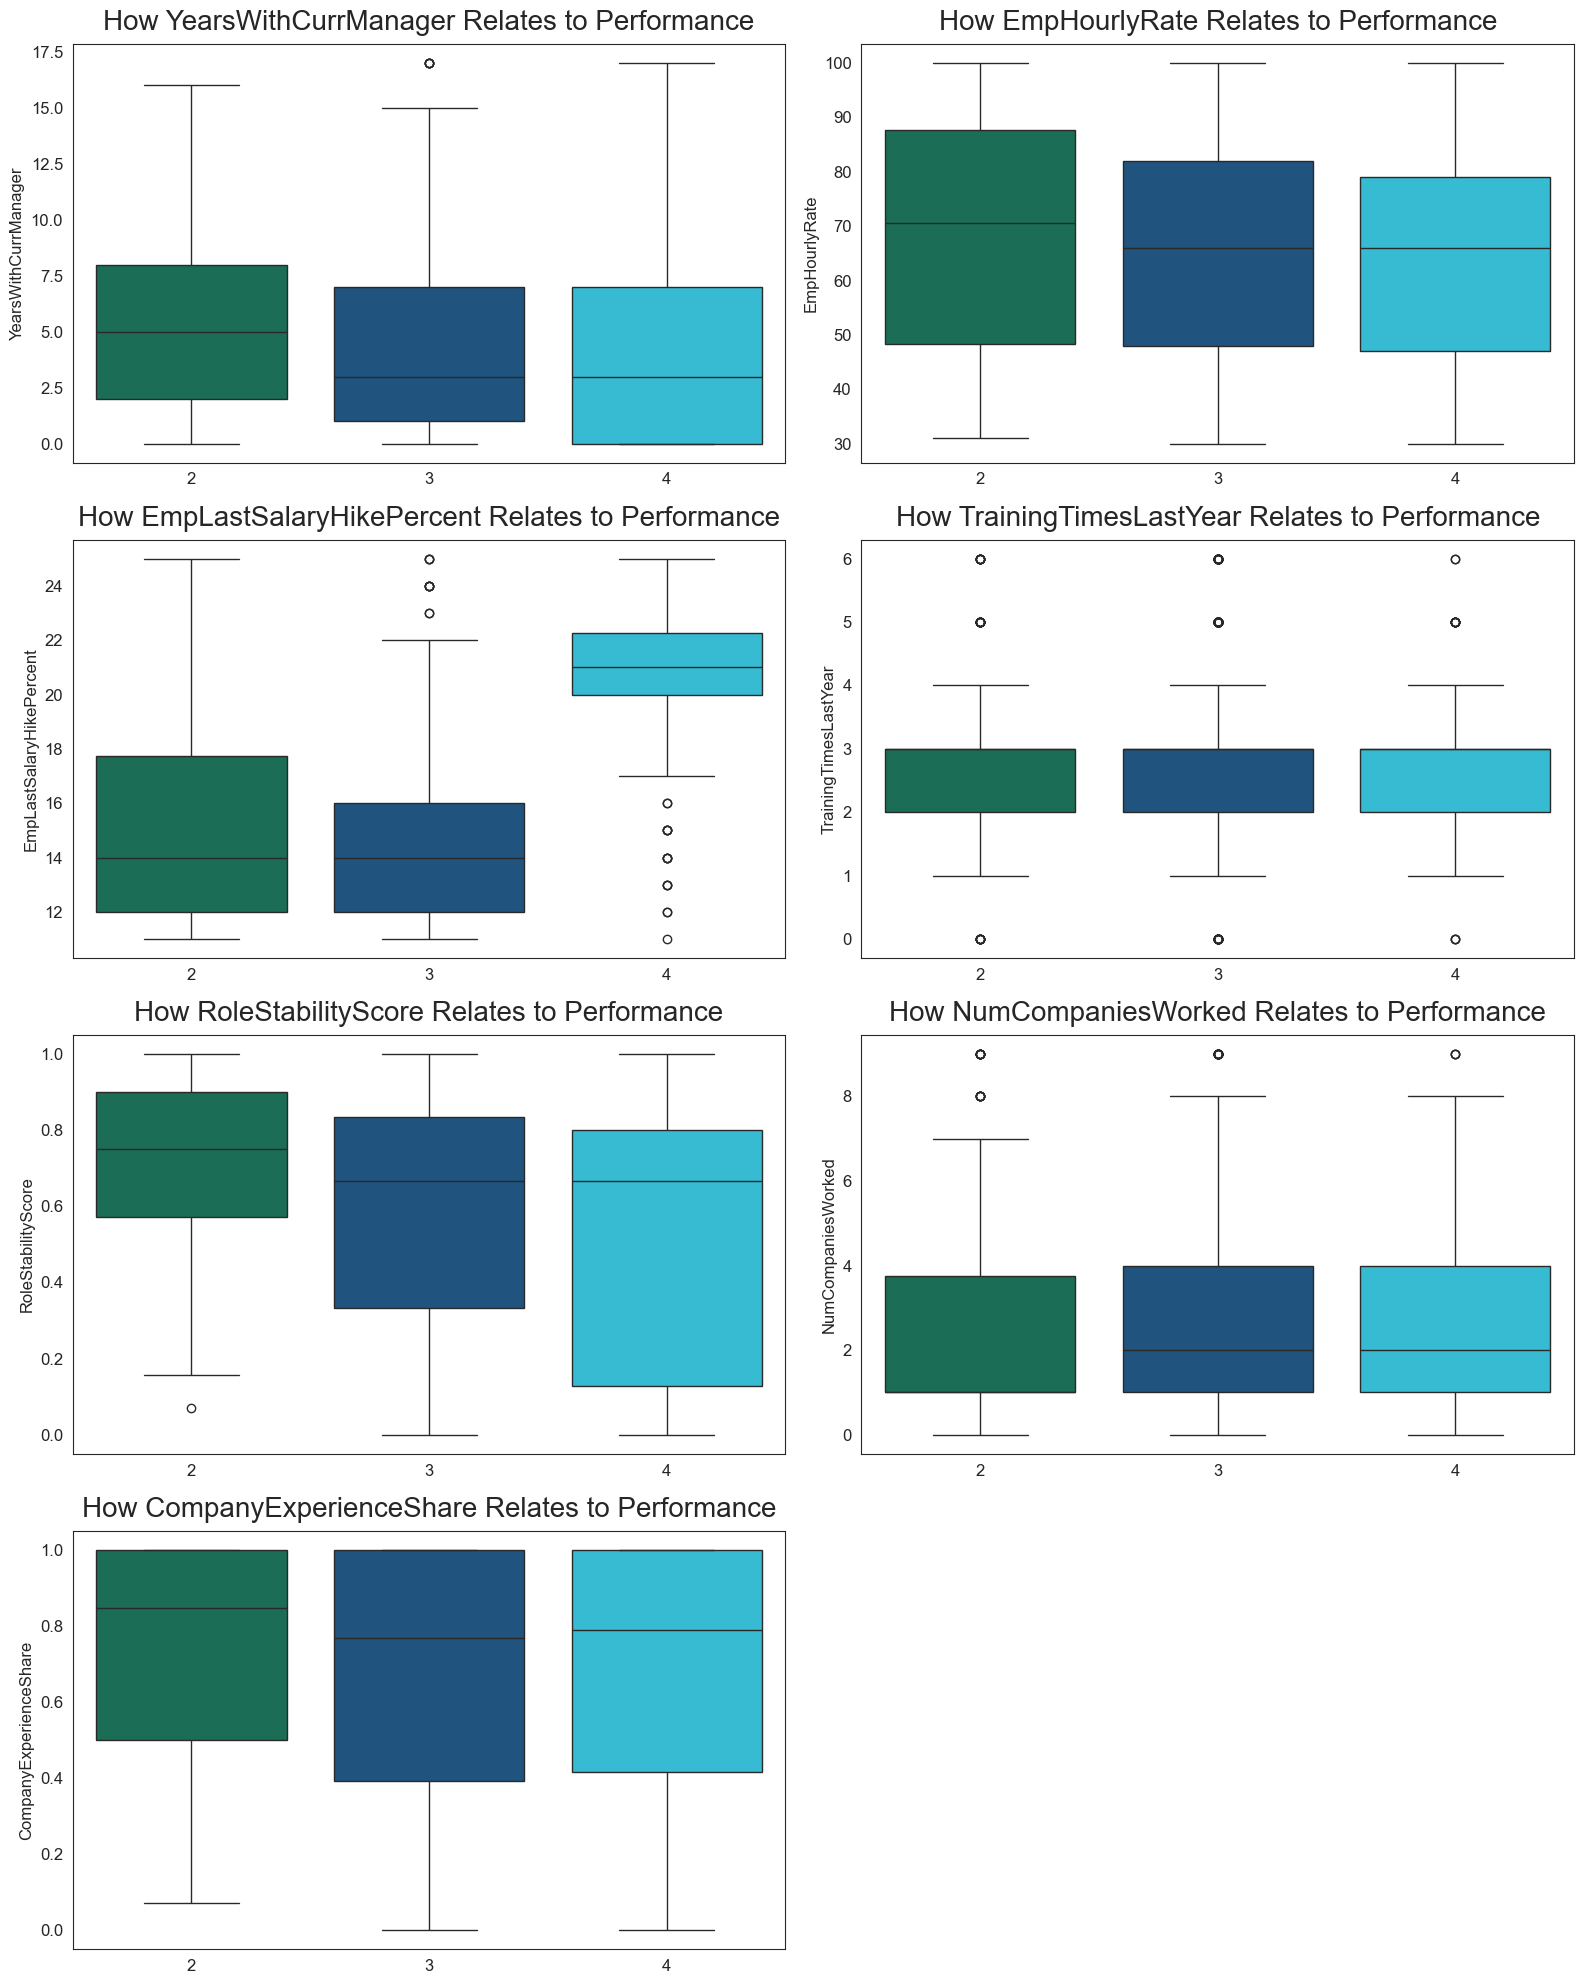

In [27]:
plt.figure(figsize=(16, 20))
# next 7 remaining features
for i, col in enumerate(numerical_features[6:], 1):
    plt.subplot(4, 2, i)
    sns.boxplot(data=df, x='PerformanceRating', y=col, palette=color)
    plt.xlabel("")
    plt.title(f'How {col} Relates to Performance', fontsize=20, pad=10)

plt.tight_layout()
plt.show()

- For **Years With Current Manager**, the distributions for all the performance ratings overlap closely, with only a slight shift in the median as ratings increase. This is not a clear indicator of performance rating.

-**Hourly pay** also shows heavy overlap across all the performance scores. This indicates that compensation level alone does not distinguish high and low performers.There are higher paid employees  that fall into lower performance ratings and lower paid employees with higher performance rating. I argue that pay may reflect role or seniority more than current performance.

- The **last Salary Hike Percent** is a very interesting one. This feature shows a clearer separation. It shows that top performers have a noticeably higher median raise compared to other groups and those with a lower last Salary Hike Percent holding a rating 4 are considered outliers. There is a clear pattern that links higher recent increases with stronger performance ratings.

- The distributions for all performance ratings in **Training Times Last Year** look similar  with similar outliers, indicating that the number of trainings does not impact performance rating.

- The **Role Stability** Score doesn't tell us much about performance because accrording to the boxplots more rating 2 performers have a slightly higher reliability score but this is spread out through out all performance rating. 

- Those in the lower performance category generally show fewer **Number of Companies Worked**, but this does not clearly indicate performance rating as  the distributions for all performance ratings overlap closely with both the highest and the lowest employees having worked at a few and many companies.

- Top performers tend to have spent a slightly larger proportion of their career at INX, as shown by a higher median. Still, a few newer employees fall into the top-performing group, highlighting that strong performance can happen even with lower company tenure.


### **c. Correlation Heat Map**

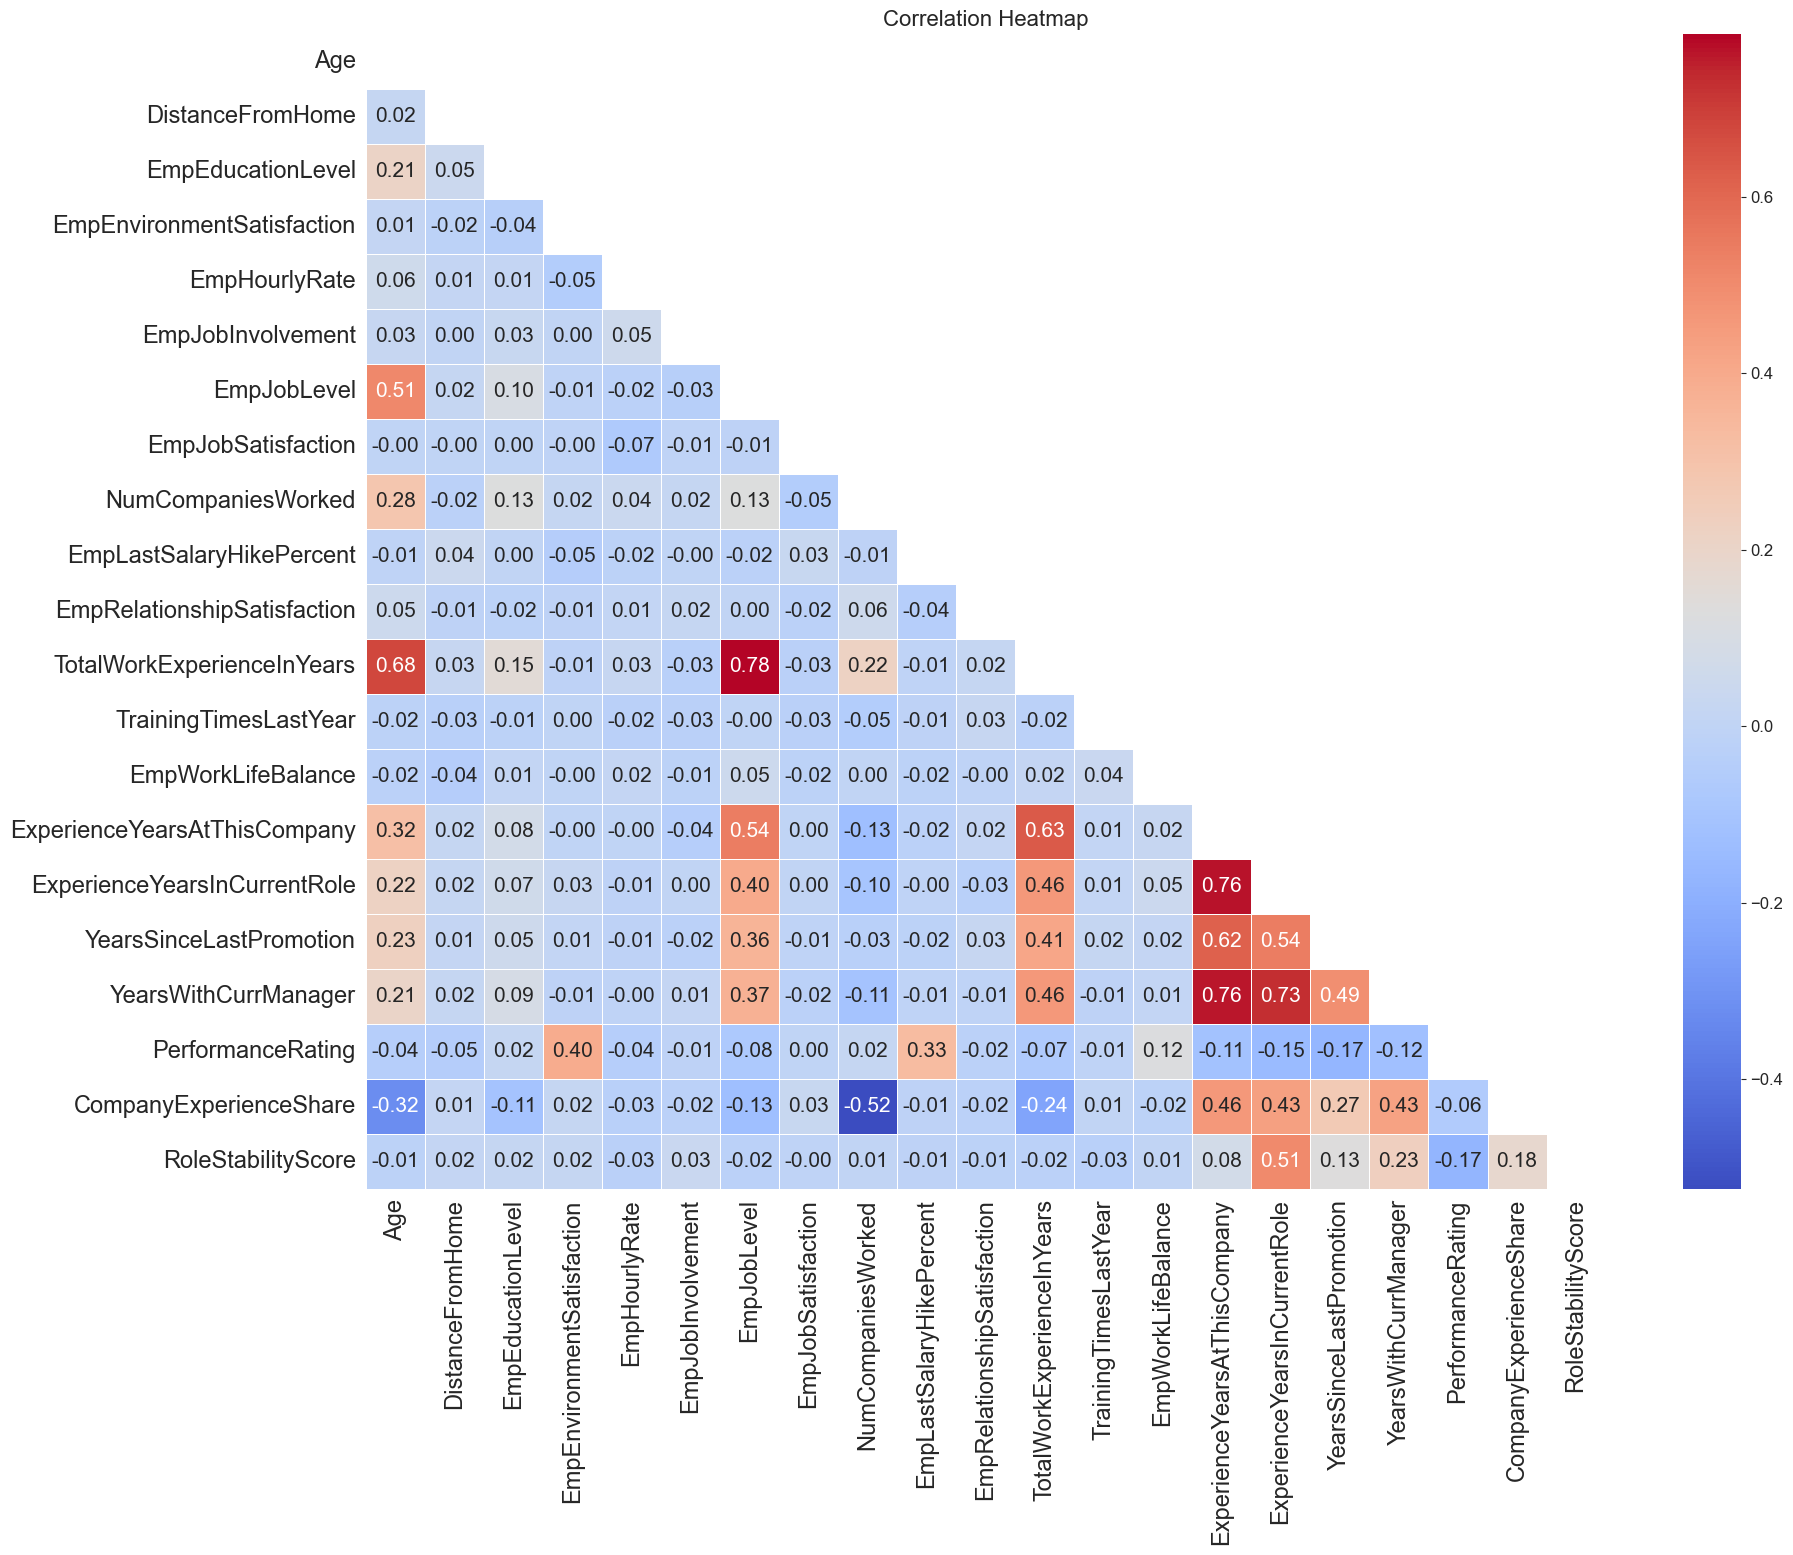

In [28]:
# we'll need a correlation matrix for numerical columns only (ordinal and continuious)
numeric_cols = df.select_dtypes(include=['int64', 'float64']) 
corr = numeric_cols.corr() 

# Create upper-triangle mask (i want a triangular heatmap) 
tri_mask= np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,15)) 
sns.heatmap(corr, annot=True, annot_kws={"size": 15},mask=tri_mask, 
            cmap='coolwarm', fmt='.2f', linewidths=.5) 
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
plt.title('Correlation Heatmap', fontsize=16) 
plt.show()

**COMMENT**

- The strongest relationship is between **TotalWorkExperienceInYears and ExperienceYearsAtThisCompany (0.78)**, meaning employees with more overall experience also tend to have more years at the company. 
- There is no coefficient above 0.8. 
- There is also a clear link between **ExperienceYearsAtThisCompany and ExperienceYearsInCurrentRole (0.63)**, which shows that longer company tenure generally comes with a longer time in the same role. 
- In contrast, **CompanyExperienceShare has a moderate negative correlation with PerformanceRating (-0.52)**, suggesting that employees who have spent a higher share of their career at the company will have  slightly lower performance ratings.
- Most other features show **weak correlations**, which means that there are **no serious multicollinearity issues** in the dataset. This means the features can be used together without distorting the model.

At the same time, **PerformanceRating is not highly correlated with most features**, which shows a **weak linear relationship with the target**. This in turn supports our decision to use **non-linear, tree-based models (Random Forest, XGBoost)**, which would be  better at capturing complex patterns than linear models. So **logistic Regression** would only be used as a baseline.


---
## **6. Data Processing**

Before modeling, let's first group the high-cardinality columns. Then we will encode the binary and categorical using mapping and one hot encoding. Next we will split the dataset into train and test sets using stratification, so that the PerformanceRating distribution stays consistent in both sets and finally target encode the high-cardinality columns and label encode the Target variable (y)

First let's organize all features into clear groups based on how they should be treated:


- Numeric features --> These are continuous values that need scaling

- Ordinal features --> These levels have meaning, so let's keep their numbers as they are

- Binary features --> will be encoded using mapping. These are simple 0/1 columns that don’t need scaling

- Low-cardinality categoricals --> These have small number of categories, so I use One-Hot Encoding

- High-cardinality categoricals --> These features have many categories, which can create noise, so we will first group the rare ones into “Other,” then apply Target Encoding with smoothing after splitting to reduce leakage.

Transformation (Scaling, Target encoding and smoothing ) is fit only on the training set and then applied to the test set.

Numeric features are scaled using StandardScaler so Logistic Regression (my baseline model) can behave properly. All tree-based models will train on the unscaled version, so I keep the encoding clean and simple.

### **i. Grouping**

In [29]:
cols_to_group =['EducationBackground', 'EmpDepartment', 'EmpJobRole']

# EducationBackground: group all the small categories
def group_edu(x):
    if x in ['Technical Degree', 'Other', 'Human Resources']:
        return 'Other'
    else:
        return x

df['EducationBackground_grouped']= df['EducationBackground'].apply(group_edu)

# EmpDepartment: group small departments
def group_dep(y):
    if y in ['Human Resources','Finance', 'Data Science']:
        return 'SmallDepts'
    else:
        return y

df['EmpDepartment_grouped'] = df['EmpDepartment'].apply(group_dep)

# EmpJobRole: Keep only roles that appear at least 10 times
job_counts = df['EmpJobRole'].value_counts()
top_roles = job_counts[job_counts >= 10].index.tolist()
def group_job_role(z):
    if z in top_roles:
        return z
    else:
        return 'MinorRoles'

df['EmpJobRole_grouped'] = df['EmpJobRole'].apply(group_job_role)

print('grouping is successfully done')

grouping is successfully done


In [30]:
# drop the original columns and keep the grouped ones
df = df.drop(cols_to_group, axis=1)
print('cols successfully dropped')

cols successfully dropped


Now let's divide our features into their various categories to keep the work clean and simple

In [31]:
# Numeric (continuous) features will be scaled
num_cols = ['Age', 'DistanceFromHome', 'TotalWorkExperienceInYears','ExperienceYearsAtThisCompany', 
                    'ExperienceYearsInCurrentRole','YearsSinceLastPromotion', 'YearsWithCurrManager','EmpHourlyRate', 
                    'EmpLastSalaryHikePercent', 'NumCompaniesWorked','CompanyExperienceShare', 'RoleStabilityScore']

# Ordinal features (1–4/5 scales) will not be scaled
ord_cols = ['EmpEducationLevel','EmpEnvironmentSatisfaction','EmpJobInvolvement','EmpJobSatisfaction',
                    'EmpRelationshipSatisfaction','EmpWorkLifeBalance']

# Binary features will be encoded (Mapping) but not scaled
binary_cols = ['Gender', 'OverTime', 'Attrition']  

# High-cardinality nominal will be target encoded but not scaled
target_cols = [ 'EducationBackground_grouped','EmpDepartment_grouped','EmpJobRole_grouped']

# Low-cardinality nominal will be one hot encoded but notscaled
one_hot_cols = ['CommuteCategory', 'MaritalStatus','PromotionWaitTime', 'BusinessTravelFrequency']  

### **ii. Encoding (mapping and one hot)**

**Comment on Encoding Strategy**

- Some categorical columns are either binary or have a clear order, so we will use mapping for `Gender`, `OverTime`, and `Attrition`. This is simple and will allow the model to easily interpret these features.

- Other categorical columns with a few categories and no natural order will be encoded using One-Hot Encoding. This works well because the number of new columns is small and does not introduce noise.

- Features like `EmpJobRole_grouped`, `EmpDepartment_grouped`, and `EducationBackground_grouped`  will be target encoded after splitting.

### a. Mapping binary columns

In [32]:
# Mapping binary features for easier model training
df['OverTime'] = df['OverTime'].map({'No': 0, 'Yes':1})
df['Attrition'] = df['Attrition'].map({'No':0, 'Yes': 1})
df['Gender']= df['Gender'].map({'Female':1, 'Male': 0})

print('Mapping successful')

Mapping successful


### b. One hot Encoding

In [33]:
# here we'll use one hot encoding using pd.get_dummies

df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

print('one hot encoding is successful')

one hot encoding is successful


In [34]:
# lets check our data before splitting

df.head()

,Age,Gender,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating,CompanyExperienceShare,RoleStabilityScore,EducationBackground_grouped,EmpDepartment_grouped,EmpJobRole_grouped,CommuteCategory_Moderate,CommuteCategory_Far,MaritalStatus_Married,MaritalStatus_Single,PromotionWaitTime_Moderate,PromotionWaitTime_Long,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely
0,32,0,10,3,4,55,3,2,4,1,0,12,4,10,2,2,10,7,0,8,0,3,1.000000,0.700000,Marketing,Sales,Sales Executive,True,False,False,True,False,False,False,True
1,47,0,14,4,4,42,3,2,1,2,0,12,4,20,2,3,7,7,1,7,0,3,0.350000,1.000000,Marketing,Sales,Sales Executive,True,False,False,True,False,False,False,True
2,40,0,5,4,4,48,2,3,1,5,1,21,3,20,2,3,18,13,1,12,0,4,0.900000,0.722222,Life Sciences,Sales,Sales Executive,False,False,True,False,False,False,True,False
3,41,0,10,4,2,73,2,5,4,3,0,15,2,23,2,2,21,6,12,6,0,3,0.913043,0.285714,Other,SmallDepts,Manager,True,False,False,False,False,True,False,True
4,60,0,16,4,1,84,3,2,1,8,0,14,4,10,1,3,2,2,2,2,0,3,0.200000,1.000000,Marketing,Sales,Sales Executive,False,True,False,True,True,False,False,True


In [35]:
# save the dataframe after preprocessing

df.to_csv('preprocessed_employee_performance.csv', index=False)

print('The dataframe has been successfully saved')

The dataframe has been successfully saved


### **iii. Splitting**

In [36]:
# splitting the data into train and test sets by stratifying the target variable

X = df.drop('PerformanceRating', axis=1)
y = df['PerformanceRating']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

print('Splitting is successful')

Splitting is successful


### **iv. Target Encoding**

In [37]:
import category_encoders as ce

te = ce.TargetEncoder(cols=target_cols, smoothing=5)

# now we fit and transform the target columns
X_train_enc =te.fit_transform(X_train[target_cols], y_train)
X_test_enc = te.transform(X_test[target_cols])

# then we create copies of X_train and X_test to keep the original data intact
X_train_final = X_train.copy()
X_test_final = X_test.copy()

# finally we replace the original target columns with the encoded ones
X_train_final[target_cols] = X_train_enc
X_test_final[target_cols]= X_test_enc

print('Target encoding is successful')

Target encoding is successful


### **v. Label Encode the target variable from [2,3,4] --> [0,1,2]**

- XGBoost expects the target variable to start from 0,1,2. Using the target variable in its original form of 2,3,4 causes an Error

In [38]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

### **iv. scaling**

Most of the models we're using are tree-based, so they don’t require scaling. Trees don’t really care about feature magnitude because they split based on thresholds, not distances. However, since I'm using Logistic Regression as a baseline, I’ll still apply scaling to the numeric features so that the baseline is fair and stable. The ordinal features (like satisfaction levels) will keep their original values because their order carries meaning. Binary features don't need scaling, and leaving them as 0/1 is okay.

In [39]:
# make copies of unscaled data for our tree models
X_train_trees = X_train_final.copy()
X_test_trees = X_test_final.copy()

# scale for  the multinomial logistic regression model
scaler = StandardScaler()
X_train_final[num_cols] = scaler.fit_transform(X_train_final[num_cols])
X_test_final[num_cols]= scaler.transform(X_test[num_cols])

print('Scaling is successful')

Scaling is successful


In [40]:
X_train_trees.head(2)

,Age,Gender,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,OverTime,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,CompanyExperienceShare,RoleStabilityScore,EducationBackground_grouped,EmpDepartment_grouped,EmpJobRole_grouped,CommuteCategory_Moderate,CommuteCategory_Far,MaritalStatus_Married,MaritalStatus_Single,PromotionWaitTime_Moderate,PromotionWaitTime_Long,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely
437,28,0,7,3,3,55,3,2,1,0,0,14,4,5,5,3,4,2,1,3,0,0.8,0.5,2.94697,2.857627,2.849765,True,False,False,True,False,False,True,False
1091,25,1,4,2,2,99,2,2,4,1,1,11,2,5,3,3,5,4,1,3,0,1.0,0.8,2.94697,2.857627,2.849765,False,False,False,True,False,False,False,True


We have successfully preprocessed the data and it is ready for modeling. We have a total of 34 features including numerical, ordinal, binary, and nominal features.

---


## **7. Model Selection and Evaluation**

We are training and comparing several models to predict and analyze employee performance:

- **Logistic Regression (multinomial with L2 regularization)** will serve as our baseline model. Apart from its simplicity, we will use it to better understand whether performance follows linear patterns. L2 (Ridge) regularization is used to handle multicollinearity and ensure that we have stable coefficients since a few of our features were correlated. 
- **Random Forest** is an ensemble tree method that captures non-linear relationships and feature interactions without overfitting. It is able to manage the mixed data types as well as imbalanced classes. It also handles feature magnitude and multicollinearity well with no scaling necessary.
- **XGBoost (Extreme Gradient Boosting)** is also a tree model that is very good for tabular data. This is due to its speed and ability to focus on hard-to-predict cases like the minority performance classes. 


**NB**: We will evaluate these models using **precision, recall, F1-score**, and **ROC-AUC** to see how well they classify employee performance. Testing multiple models helps us to identify the one that works best in practice.  

**Why we don’t rely on Accuracy**  
- From early on we knew that accuracy alone would mislead us. This is because we observed an imbalance of performance rating classes, with 73% of employees rated 3. Therefore, a model predicting rating 3 would score 73% accuracy yet fail completely at the real task of identifying those who need support (rating 2) and those who deserve recognition (rating 4).
- The real goal is to correctly identify the minority classes (ratings 2 and 4) — the employees who are performing well enough or top performers. Metrics like **precision, recall, and ROC-AUC** give a more meaningful view of model performance.

**What our metrics mean**

- **Precision**: Of the employees flagged as top performers, how many truly are. This would helps HR avoid promoting the wrong people.

- **Recall**: Of all real top performers, how many did we actually catch. This is so we don’t miss hidden Outstanding performers.

- **F1-Score**: Balances precision and recall and it is our main metric for choosing the best model.

- **ROC–AUC**: Shows how well the model ranks employees by performance.

Together, these metrics make sure the model works fairly and not just for the majority.

### **i. Train Models**

In [41]:
# logistic regression (use the l2 regularization)

lr = LogisticRegression(max_iter=1000, C=1.0, random_state=42, penalty='l2',
                        solver='lbfgs', multi_class='multinomial')
lr.fit(X_train_final, y_train_enc)

# Random Forest

rf = RandomForestClassifier(n_estimators=100, max_depth = 10,min_samples_split=10,
                            random_state=42, n_jobs=-1 )
rf.fit(X_train_trees, y_train_enc)

# XGBOOST

xgb = XGBClassifier(n_estimators=80, eval_metric='mlogloss', max_depth=10, 
                    learning_rate= 0.1, random_state=42)
xgb.fit(X_train_trees, y_train_enc)

print('Models have been successfully trained')

Models have been successfully trained


### **ii. Model Performance**

Logistic Regression
ROC-AUC: 0.8996
Precision =0.804
Recall = 0.817
F1-Score = 0.806
              precision    recall  f1-score   support

           0       0.57      0.41      0.48        39
           1       0.85      0.93      0.89       175
           2       0.86      0.69      0.77        26

    accuracy                           0.82       240
   macro avg       0.76      0.68      0.71       240
weighted avg       0.80      0.82      0.81       240



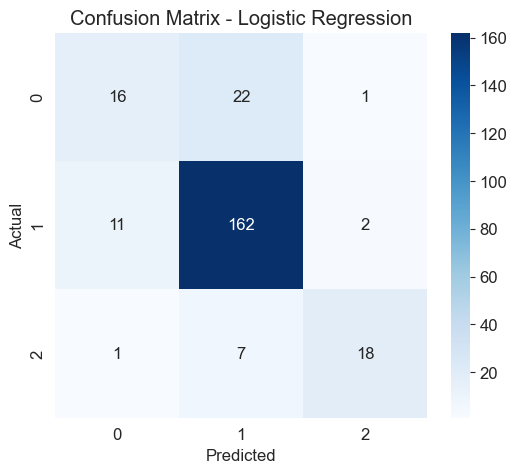

In [42]:
# Logistic Regression evaluation
# let's predict
y_pred_lr = lr.predict(X_test_final)
y_proba_lr = lr.predict_proba(X_test_final)

# then evaluate with our metrics
# we also want the average scores
roc_auc = roc_auc_score(y_test_enc,y_proba_lr, multi_class="ovr", average="weighted" )
precision = precision_score(y_test_enc, y_pred_lr, average="weighted")
recall = recall_score(y_test_enc, y_pred_lr, average="weighted")
f1 = f1_score(y_test_enc, y_pred_lr, average="weighted")

# now we print the results
print("Logistic Regression")
print("ROC-AUC:", round(roc_auc, 4))
print(f"Precision ={precision:.3f}")
print(f"Recall = {recall:.3f}")
print(f"F1-Score = {f1:.3f}")
print(classification_report(y_test_enc, y_pred_lr))

# Generate confusion matrix and plot it
cm= confusion_matrix(y_test_enc, y_pred_lr)
labels= sorted(list(set(y_test_enc))) 

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Next, are the tree models evaluation


 Random Forest 
ROC-AUC: 0.9507
Precision =0.931
Recall = 0.929
F1-Score = 0.927
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        39
           1       0.92      0.98      0.95       175
           2       1.00      0.73      0.84        26

    accuracy                           0.93       240
   macro avg       0.95      0.84      0.89       240
weighted avg       0.93      0.93      0.93       240



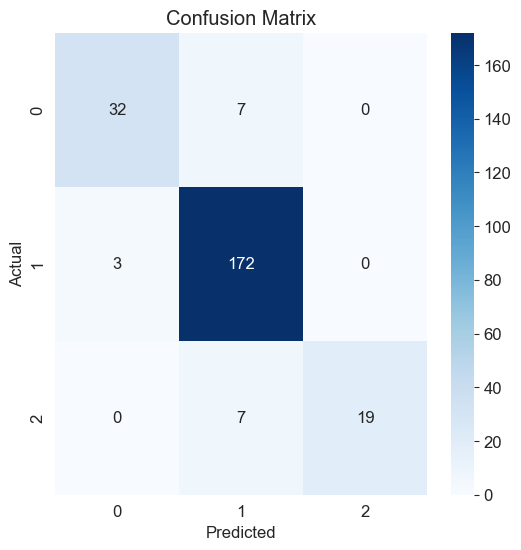


 XGBoost 
ROC-AUC: 0.9756
Precision =0.941
Recall = 0.942
F1-Score = 0.940
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        39
           1       0.95      0.98      0.96       175
           2       0.96      0.85      0.90        26

    accuracy                           0.94       240
   macro avg       0.94      0.88      0.91       240
weighted avg       0.94      0.94      0.94       240



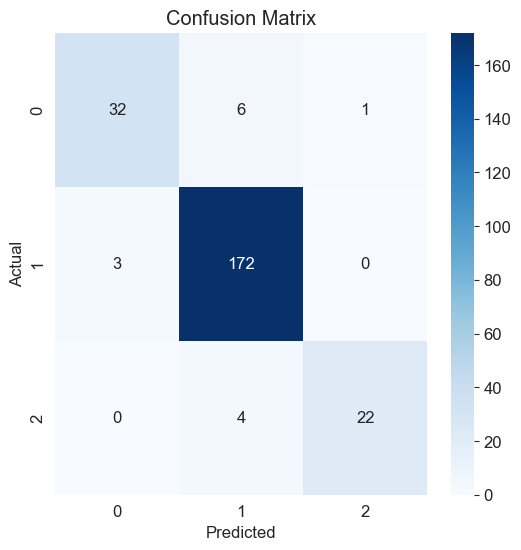

In [43]:
# Random Forest and XGBOOST evaluation
# we'll print the evaluation metrics for both models and the confusion matrix

tree_models = {'Random Forest':rf, 'XGBoost':xgb}

for model_name, model in tree_models.items():
    #let's predict
    y_pred= model.predict(X_test_trees)
    y_proba = model.predict_proba(X_test_trees)

    # then evaluate
    # we also want the average scores for all classes for each model
    roc_auc = roc_auc_score(y_test_enc, y_proba, multi_class="ovr", average="weighted")
    precision = precision_score(y_test_enc, y_pred, average="weighted")
    recall= recall_score(y_test_enc, y_pred, average="weighted")
    f1 = f1_score(y_test_enc, y_pred, average="weighted")

    # then we print the results
    print(f"\n {model_name} ")
    print("ROC-AUC:", round(roc_auc, 4))
    print(f"Precision ={precision:.3f}")
    print(f"Recall = {recall:.3f}")
    print(f"F1-Score = {f1:.3f}")
    print(classification_report(y_test_enc, y_pred))

    # Generate confusion matrix then plot it
    cm= confusion_matrix(y_test_enc, y_pred)
    labels= sorted(list(set(y_test_enc))) 

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## **Model Performance Insight**

**Logistic Regression** 

- Logistic Regression has an overall F1-score of 0.81, which shows only moderate performance compared to the other models.
- It struggled the most with the minority classes, scoring an F1 of 0.48 for good performers (Rating 2) and 0.77 for outstanding performers (Rating 4). 
- This means it missed a large number of employees who actually needed attention or recognition. 
- Though this model is simple and interpretable,it couldn't capture the more complex interactions in the due to its linear nature. 

Therefore, it is not reliable enough for performance-based decision-making.

**Random Forest**

- Random Forest improved significantly on the baseline with an overall F1-score of 0.93. 
It was very effective at detecting good performers, achieving an F1-score of 0.86 for Rating 2, meaning the majority of underperforming employees were correctly identified. 
- It also performed strongly for outstanding performers with an F1-score of 0.84 for Rating 4, and showed excellent precision, rarely mislabeling average employees as top performers.
-  However, it still missed 7 out of 26 top performers, which shows a slight weakness in spotting hidden outstanding employees. 

Overall, it has proved to be a strong model for identifying performance risks.

**XGBoost** --> (Winning Model)

- XGBoost had the best results across all evaluation metrics. It had an overall F1-score of 0.94 and a ROC-AUC score of 0.975. 
- Like RandomForest it achieved an F1-score of 0.86 for low performers but got a 0.90 F1-score for top performers, which is the highest among all models. 
- It correctly identified 32 out of 39 good performers and 22 out of 26 outstanding performers, missing the fewest cases out of all the models.
- It also avoided serious errors, such as incorrectly labeling top performers as low performers. 

These results show that XGBoost has learned the true structure of the data and has balanced both precision and recall more effectively than the other models.

### iii **So what drives high performance?**

We will use feature importance to find the best 3 drivers of performance and answer this question

In [44]:
# Now let's calculate the Feature importance score
importance= xgb.feature_importances_
feat= X_train_trees.columns

feat_importance = pd.DataFrame({'Feature': feat,'Importance': importance}).sort_values(by='Importance',ascending=False)
print(feat_importance)

                                      Feature  Importance
4                  EmpEnvironmentSatisfaction    0.210782
18                    YearsSinceLastPromotion    0.150500
11                   EmpLastSalaryHikePercent    0.134011
24                      EmpDepartment_grouped    0.093009
17               ExperienceYearsInCurrentRole    0.047768
16               ExperienceYearsAtThisCompany    0.030864
15                         EmpWorkLifeBalance    0.026388
19                       YearsWithCurrManager    0.020086
23                EducationBackground_grouped    0.018246
22                         RoleStabilityScore    0.015511
25                         EmpJobRole_grouped    0.014985
33      BusinessTravelFrequency_Travel_Rarely    0.014590
6                           EmpJobInvolvement    0.013532
10                                   OverTime    0.013492
29                       MaritalStatus_Single    0.013470
3                           EmpEducationLevel    0.013470
12            

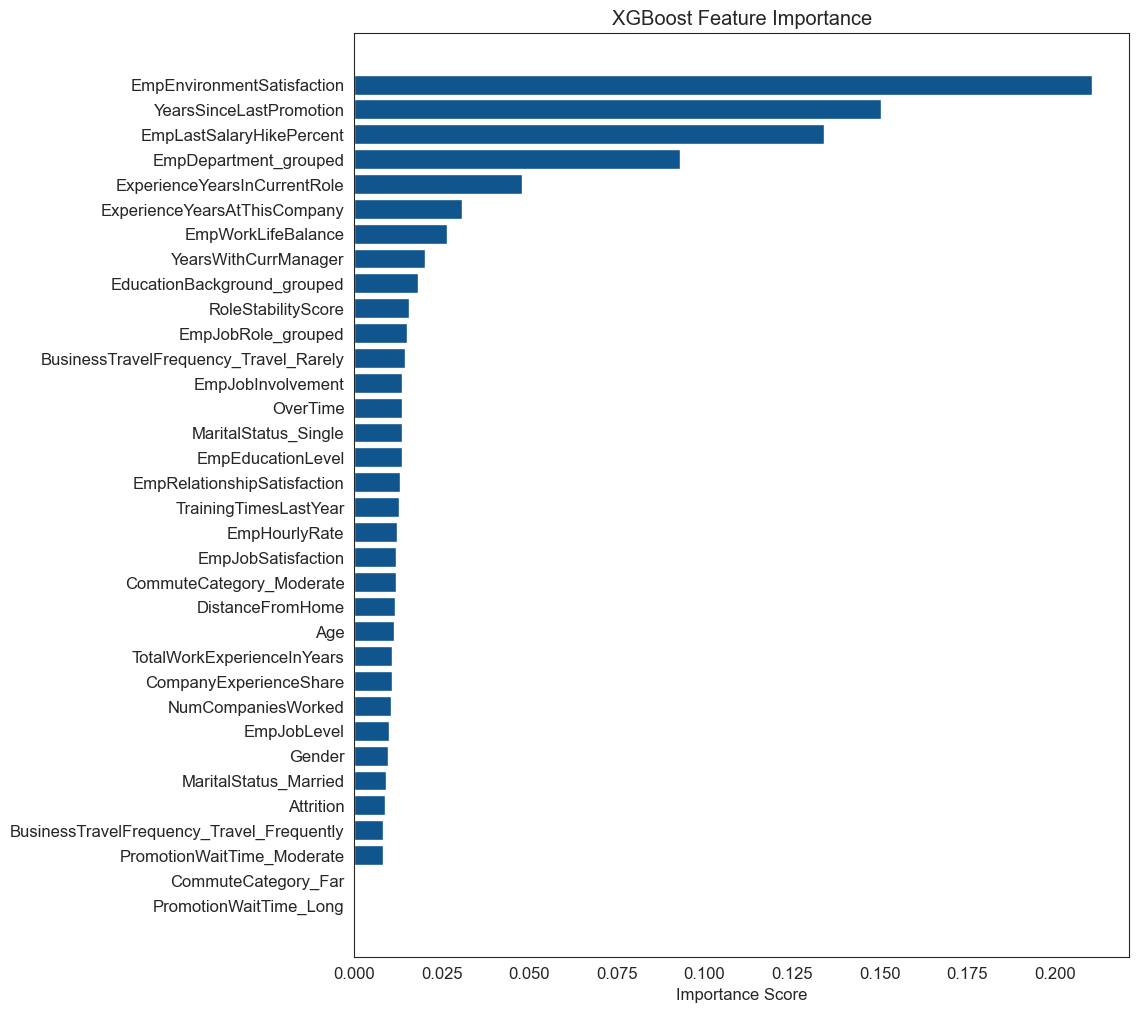

In [45]:
# Then we plot feature importance chart
plt.figure(figsize=(10, 12))
plt.barh(feat_importance['Feature'], feat_importance['Importance'],color ="#10558d")
plt.xlabel("Importance Score")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### **Answer to : What drives high performance?**

 Based on 1,200 employee records, performance is influenced mostly by satisfaction and recognition, and not personal demographics. According to the feature importance list, the top three factors explain nearly 50% of performance variance.

**1. Work Environment Satisfaction (21%)**
This highlights that feeling supported and valued consistently in the work place produces top performers. It shows that a strong positive environment is more important to employees than tenure, job role, or pay.

**2. Time Since Last Promotion (15%)**
Employees who have been waiting more years for a promotion are far more likely to underperform. This indicates that recognition is an important factor that drives performance.

**3. Recent Salary Hike (13%)**
Compensation isn’t the main driver but recognition through pay is. Workers who obtained significant pay raises in the cycle demonstrate better performance indicating that feeling appreciated leads to greater effort.


**Other Influential Factors**
- Department (9%) --> The department that an eployee belongs in has an infuence on performance
 for example, Development department outperforms and the Finance department lags behind.
- Role Tenure (5%) --> Staying too long in the same role reduces performance.


**Minimal Impact :**
Demographics such as gender, age, marital status, commute distance, Education and job level have minor impact on performance.

This concludes our analysis and model building for the Employee Performance dataset. We do not need hyperparameter tuning as the models are performing well with default parameters. Next we will deploy the best model using streamlit but first let's save the model and all the necessary objects using joblib. 

NB: Find the Recommendations right after

In [46]:
#let's deploy the best model (XGBoost) and save necessary objects using joblib
import joblib

# Save model
joblib.dump(xgb, 'models/xgb_model.pkl')

# Save target encoder (for grouped features)
joblib.dump(te, 'models/target_encoder.pkl')

# Save label encoder (for y)
joblib.dump(le, 'models/label_encoder.pkl')

# Save feature order
joblib.dump(list(X_train_trees.columns), 'models/feature_order.pkl')

# Save binary mappings as dict (or hardcode in app)
binary_maps = {'OverTime': {'No': 0, 'Yes': 1},'Gender': {'Female': 0, 'Male': 1}, 'Attrition': {'No': 0, 'Yes': 1}}

joblib.dump(binary_maps, 'models/binary_mappings.pkl')

['models/binary_mappings.pkl']

## **Recommendations**

1. **Improve the work environment.**
It is important to focus on creating a supportive work environment. This is the most important driver of performance. We should invest more in employee recognition programs by rewarding outstanding performers as well as providing mentorship for at-risk performers. By nurturing a positive culture, we will help sustain high performance across teams.

2. **Evaluate promotion patterns**
We should Identify employees who have gone more than 3 years without a promotion. Developing growth and development plans to re-engage the employees will encourage them. Also, timely recognition and progression can prevent disengagement and improve overall performance.

3. **Link pay directly to performance results**
Ensuring that raises and bonuses don't solely depend on how long someone has been in the company but also on how well they actually perform will improve morale. Also, recognizing and rewarding top performers reinforces the right behaviors and in turn helps us keep the high-potential talent.

4. **Investigate Finance's  underperformance.**  
A thorough assessment of structural issues, or even leadership effectiveness should be conducted within the Finance department. We should aim to identify the gaps in processes, or team support that may be holding employees back.Find the root causes, and address them boost overall performance.

## **Conclusion**

This analysis clearly indicates that employee performance at INX Future Inc. is driven primarily by recognition, and work environment, and not the demographic factors such as gender, age, or commute distance.  

NB: This model can also be used to support hiring decisions, but only to a certain extent. It can be used to identify common patterns among high performers, but should not replace human judgment. But don’t use it to directly score candidates, because some features (like promotion history) don’t exist pre-hire.

Future Work

To strengthen this work:

- Test interventions: Does promotion or recognition measurably improve performance?
- Build a talent dashboard: Track at-risk and high-potential employees quarterly
- Expand the data: Add feedback, manager ratings, and also project outcomes.

By focusing on the factors that truly matter, INX Future Inc. can build a more engaged, productive, and high-performing workforce.
